In [1]:
import tensorflow as tf

import numpy as np

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras import optimizers
from pandas import Series
import math
import numpy
from tensorflow.keras.layers import *
from tensorflow.keras import layers
import pandas as pd

#data = pd.read_csv('bitcoin.csv')
data = pd.read_csv('bitcoin2000.csv')

In [21]:
def gradient_importance(seq, model):

    seq = tf.Variable(seq[np.newaxis,:,:], dtype=tf.float32)

    with tf.GradientTape() as tape:
        predictions = model(seq)

    grads = tape.gradient(predictions, seq)
    grads = tf.reduce_mean(grads, axis=1).numpy()[0]
    
    return grads

def gradient_weight(seq, model):

    seq = tf.Variable(seq[np.newaxis,:,:], dtype=tf.float32)

    with tf.GradientTape() as tape:
        predictions = model(seq)

    grad = tape.gradient(predictions, seq)
    #gr=grads
    #grads = tf.reduce_mean(grads, axis=1).numpy()[0]
    
    return grad


def activation_grad(seq, model):
    
    seq = seq[np.newaxis,:,:]
    grad_model = Model([model.inputs], 
                       [model.get_layer('extractor').output, 
                        model.output])

    # Obtain the predicted value and the intermediate filters
    with tf.GradientTape() as tape:
        seq_outputs, predictions = grad_model(seq)

    # Extract filters and gradients
    output = seq_outputs[0]
    grads = tape.gradient(predictions, seq_outputs)[0]

    # Average gradients spatially
    weights = tf.reduce_mean(grads, axis=0)
    
    # Get a ponderated map of filters according to grad importance
    cam = np.ones(output.shape[0], dtype=np.float32)
    for index, w in enumerate(weights):
        cam += w * output[:, index]

    time = int(seq.shape[1]/output.shape[0])
    cam = zoom(cam.numpy(), time, order=1)
    heatmap = (cam - cam.min())/(cam.max() - cam.min())
    
    return heatmap

In [3]:
data.set_index(['timeUTC'],inplace=True)
#data = data['item_cnt_day'].resample('D').sum()
df=pd.DataFrame(data)

In [4]:
df

,time,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol
timeUTC,,,,,,,,,
2019-12-12 19:00:00,1576144800,7219.93,7149.15,7170.18,1536.79,11041994.81,7166.14,direct,NaN
2019-12-12 20:00:00,1576148400,7208.36,7166.03,7166.14,785.11,5654607.43,7199.79,direct,NaN
2019-12-12 21:00:00,1576152000,7222.43,7194.87,7199.79,672.46,4855213.22,7199.97,direct,NaN
2019-12-12 22:00:00,1576155600,7211.80,7187.29,7199.97,807.61,5821087.81,7201.38,direct,NaN
2019-12-12 23:00:00,1576159200,7229.22,7152.84,7201.38,1606.06,11537799.57,7173.50,direct,NaN
...,...,...,...,...,...,...,...,...,...
2021-02-01 11:00:00,1612144800,33847.46,33257.39,33450.01,2066.49,69445570.35,33675.45,direct,NaN
2021-02-01 12:00:00,1612148400,33779.76,33505.50,33675.45,1173.82,39473368.04,33590.20,direct,NaN
2021-02-01 13:00:00,1612152000,33945.41,33404.87,33590.20,1430.06,48159838.72,33576.82,direct,NaN


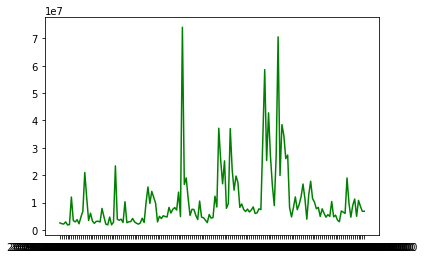

In [5]:
plt.plot(data['volumeto'][40:200],'g')

In [6]:
data.columns[1:7]

Index(['high', 'low', 'open', 'volumefrom', 'volumeto', 'close'], dtype='object')

In [7]:
from sklearn.preprocessing import MinMaxScaler
values = data[data.columns[1:7]].values.reshape(-1,6)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
#scaled = (values-(np.min(values)))/(np.max(values)-(np.min(values)))

In [8]:
values.min(axis=0)

array([4.6234502e+03, 3.9489199e+03, 4.2406899e+03, 1.6186000e+02,
       1.1648342e+06, 4.2406899e+03], dtype=float32)

In [9]:
np.max(values)

7859574300.0

In [26]:
train_size = int(len(scaled) * 0.80)
val_size = int(len(scaled) * 0.10)

test_size = len(scaled) - train_size-val_size
train,val, test,test1 = scaled[0:train_size,:],scaled[train_size:train_size+val_size,:], scaled[train_size+val_size:,:],values[train_size+val_size:,:]
print(len(train),len(val), len(test),len(test1))

8004 1000 1001 1001


In [11]:
def create_dataset_mul(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back, -1])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [37]:
look_back = 24
trainX, trainY = create_dataset_mul(train, look_back)
valX, valY = create_dataset_mul(val, look_back)
testX, testY = create_dataset_mul(test, look_back)
test1X, test1Y = create_dataset_mul(test1, look_back)

7980
976
977
977


In [13]:
print(trainX.shape)
print(trainY.shape)

(7980, 24, 6)
(7980,)


In [13]:
class CharacterTable(object):
    def __init__(self, chars):
        """Initialize character table.
        # Arguments
            chars: Characters that can appear in the input.
        """
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))

    def encode(self, C, num_rows):
        """One hot encode given string C.
        # Arguments
            num_rows: Number of rows in the returned one hot encoding. This is
                used to keep the # of rows for each data the same.
        """
        x = np.zeros((num_rows, len(self.chars)))
        for i, c in enumerate(C):
            x[i, self.char_indices[c]] = 1
        return x

    def decode(self, x, calc_argmax=True):
        if calc_argmax:
            x = x.argmax(axis=-1)
        return ''.join(self.indices_char[x] for x in x)

### bidirectional LSTM

In [126]:
first_input = Input(shape=(trainX.shape[1],trainX.shape[2]))

in1=Bidirectional(LSTM(90))(first_input)
in1=Dense(1,activation='relu')(in1)
model=Model(first_input,in1)
model.compile(optimizer='adam', loss='mse')
model.summary()
checkpoint_path = "saved_weights/bitcoin_bilstm.hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)
# fit model


Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, 12, 4)]           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 180)               68400     
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 181       
Total params: 68,581
Trainable params: 68,581
Non-trainable params: 0
_________________________________________________________________


In [127]:
model.fit(trainX, trainY,validation_data=[valX,valY], epochs=200, verbose=1,callbacks=[cb])

Train on 7992 samples, validate on 988 samples
Epoch 1/200
7808/7992 [============================>.] - ETA: 0s - loss: 5.8984e-04
Epoch 00001: val_loss improved from inf to 0.00008, saving model to saved_weights/bitcoin_bilstm.hdf5
7992/7992 [==============================] - 5s 676us/sample - loss: 5.7657e-04 - val_loss: 8.3026e-05
Epoch 2/200
7968/7992 [============================>.] - ETA: 0s - loss: 1.3286e-05
Epoch 00002: val_loss improved from 0.00008 to 0.00007, saving model to saved_weights/bitcoin_bilstm.hdf5
7992/7992 [==============================] - 2s 216us/sample - loss: 1.3317e-05 - val_loss: 6.5697e-05
Epoch 3/200
7872/7992 [============================>.] - ETA: 0s - loss: 1.3458e-05
Epoch 00003: val_loss improved from 0.00007 to 0.00006, saving model to saved_weights/bitcoin_bilstm.hdf5
7992/7992 [==============================] - 2s 213us/sample - loss: 1.3372e-05 - val_loss: 5.9518e-05
Epoch 4/200
7968/7992 [============================>.] - ETA: 0s - loss: 1.230

7992/7992 [==============================] - 2s 215us/sample - loss: 4.5545e-06 - val_loss: 1.9188e-05
Epoch 33/200
7840/7992 [============================>.] - ETA: 0s - loss: 4.8481e-06
Epoch 00033: val_loss did not improve from 0.00002
7992/7992 [==============================] - 2s 210us/sample - loss: 4.8200e-06 - val_loss: 2.8977e-05
Epoch 34/200
7968/7992 [============================>.] - ETA: 0s - loss: 4.3416e-06
Epoch 00034: val_loss improved from 0.00002 to 0.00002, saving model to saved_weights/bitcoin_bilstm.hdf5
7992/7992 [==============================] - 2s 215us/sample - loss: 4.3338e-06 - val_loss: 1.9096e-05
Epoch 35/200
7968/7992 [============================>.] - ETA: 0s - loss: 4.6427e-06
Epoch 00035: val_loss did not improve from 0.00002
7992/7992 [==============================] - 2s 213us/sample - loss: 4.6355e-06 - val_loss: 2.1785e-05
Epoch 36/200
7872/7992 [============================>.] - ETA: 0s - loss: 4.4395e-06
Epoch 00036: val_loss did not improve fr

Epoch 99/200
7872/7992 [============================>.] - ETA: 0s - loss: 3.1159e-06
Epoch 00099: val_loss did not improve from 0.00001
7992/7992 [==============================] - 2s 210us/sample - loss: 3.1446e-06 - val_loss: 1.4618e-05
Epoch 100/200
7968/7992 [============================>.] - ETA: 0s - loss: 3.4193e-06
Epoch 00100: val_loss did not improve from 0.00001
7992/7992 [==============================] - 2s 213us/sample - loss: 3.4159e-06 - val_loss: 1.4617e-05
Epoch 101/200
7968/7992 [============================>.] - ETA: 0s - loss: 3.2700e-06
Epoch 00101: val_loss did not improve from 0.00001
7992/7992 [==============================] - 2s 214us/sample - loss: 3.2738e-06 - val_loss: 1.8706e-05
Epoch 102/200
7840/7992 [============================>.] - ETA: 0s - loss: 3.0662e-06
Epoch 00102: val_loss did not improve from 0.00001
7992/7992 [==============================] - 2s 212us/sample - loss: 3.0504e-06 - val_loss: 1.5828e-05
Epoch 103/200
7968/7992 [================

Epoch 133/200
7968/7992 [============================>.] - ETA: 0s - loss: 3.1345e-06
Epoch 00133: val_loss did not improve from 0.00001
7992/7992 [==============================] - 2s 213us/sample - loss: 3.1335e-06 - val_loss: 1.4871e-05
Epoch 134/200
7968/7992 [============================>.] - ETA: 0s - loss: 3.1125e-06
Epoch 00134: val_loss did not improve from 0.00001
7992/7992 [==============================] - 2s 212us/sample - loss: 3.1082e-06 - val_loss: 2.9558e-05
Epoch 135/200
7872/7992 [============================>.] - ETA: 0s - loss: 3.1946e-06
Epoch 00135: val_loss did not improve from 0.00001
7992/7992 [==============================] - 2s 211us/sample - loss: 3.1725e-06 - val_loss: 1.5990e-05
Epoch 136/200
7968/7992 [============================>.] - ETA: 0s - loss: 3.2322e-06
Epoch 00136: val_loss did not improve from 0.00001
7992/7992 [==============================] - 2s 213us/sample - loss: 3.2327e-06 - val_loss: 1.4627e-05
Epoch 137/200
7968/7992 [===============

Epoch 167/200
7968/7992 [============================>.] - ETA: 0s - loss: 3.1431e-06
Epoch 00167: val_loss did not improve from 0.00001
7992/7992 [==============================] - 2s 213us/sample - loss: 3.1400e-06 - val_loss: 1.5210e-05
Epoch 168/200
7872/7992 [============================>.] - ETA: 0s - loss: 3.2700e-06
Epoch 00168: val_loss did not improve from 0.00001
7992/7992 [==============================] - 2s 210us/sample - loss: 3.2747e-06 - val_loss: 1.6153e-05
Epoch 169/200
7968/7992 [============================>.] - ETA: 0s - loss: 3.0647e-06
Epoch 00169: val_loss did not improve from 0.00001
7992/7992 [==============================] - 2s 213us/sample - loss: 3.0576e-06 - val_loss: 1.6655e-05
Epoch 170/200
7968/7992 [============================>.] - ETA: 0s - loss: 3.2151e-06
Epoch 00170: val_loss did not improve from 0.00001
7992/7992 [==============================] - 2s 213us/sample - loss: 3.2124e-06 - val_loss: 1.6425e-05
Epoch 171/200
7872/7992 [===============

In [128]:
model.load_weights("saved_weights/bitcoin_bilstm.hdf5")

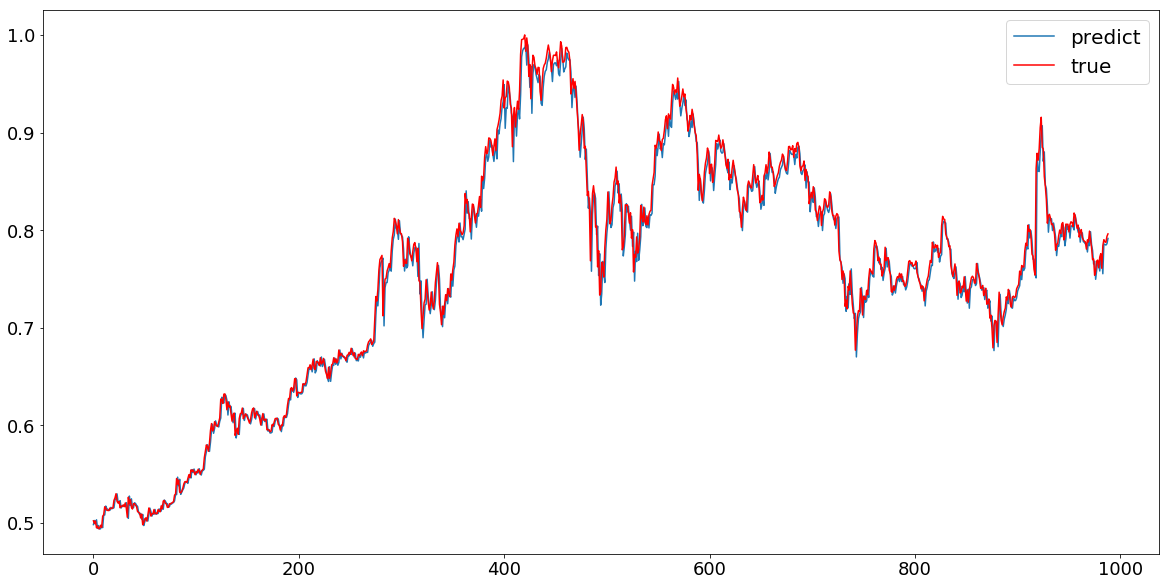

Test RMSE: 0.01266
Test MAE: 0.00895
Test MSE: 0.00016
Test RMSE: 481.45603
Test MAE: 340.22086


In [129]:

from sklearn.metrics import *
from matplotlib import pyplot
yhat = model.predict([testX])
yhat=yhat.reshape(-1,1)

plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY,'r', label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)

yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)


rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(yhat_inverse, testY_inverse)
print('Test MAE: %.5f' % mae)

### LSTM-CNN

In [51]:
from tensorflow.keras.models import Model

first_input = Input(shape=(24,6))


in0=LSTM(64,return_sequences=True)(first_input)
#in0=add([first_input,in0])
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)
#in1=MaxPooling1D(pool_size=2)(in1)#ad=Dropout(0.5)(ad)

#in1=add([in0,in1])

#ad=Dropout(0.5)(ad)
#in0=LSTM(64,return_sequences=True)(ad)
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same',name='extractor')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=add([in0,in1],name='extractor1')
#in1=MaxPooling1D(pool_size=2)(in1)#ad=Dropout(0.5)(ad)

in1=Flatten()(in1)
#model.add(LSTM(units = 128, return_sequences=True))
#in1=LSTM(units =50 , return_sequences=False)(in1)
#lstm_out=Bidirectional(LSTM(units =100 , return_sequences=False))(lstm_out)

#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1, in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2)(in1)

#flat_out = Flatten()(in1)
#flat_out=Dense(20, activation='relu')(flat_out)
#model.add(Dropout(drop_dense))
out1=Dense(1, activation = 'relu')(in1)
model=Model(inputs=first_input, outputs=out1)
model.compile(optimizer='adam', loss='mse')

checkpoint_path = "saved_weights/btc_lstmcnn_24.hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)


In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 24, 6)]      0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 24, 64)       18176       input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 24, 64)       12352       lstm[0][0]                       
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 24, 64)       8256        conv1d[0][0]                     
______________________________________________________________________________________________

In [72]:
history=model.fit(trainX, trainY, epochs=400, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

Train on 7980 samples, validate on 976 samples
Epoch 1/400
7700/7980 [===========================>..] - ETA: 0s - loss: 0.0010
Epoch 00001: val_loss improved from inf to 0.00025, saving model to saved_weights/btc_lstmcnn_24.hdf5
7980/7980 [==============================] - 3s 379us/sample - loss: 0.0010 - val_loss: 2.4784e-04
Epoch 2/400
7700/7980 [===========================>..] - ETA: 0s - loss: 2.6833e-05
Epoch 00002: val_loss did not improve from 0.00025
7980/7980 [==============================] - 1s 147us/sample - loss: 2.6533e-05 - val_loss: 2.4891e-04
Epoch 3/400
7700/7980 [===========================>..] - ETA: 0s - loss: 2.4629e-05
Epoch 00003: val_loss did not improve from 0.00025
7980/7980 [==============================] - 1s 146us/sample - loss: 2.4531e-05 - val_loss: 3.2109e-04
Epoch 4/400
7700/7980 [===========================>..] - ETA: 0s - loss: 2.2624e-05
Epoch 00004: val_loss improved from 0.00025 to 0.00020, saving model to saved_weights/btc_lstmcnn_24.hdf5
7980/7

Epoch 65/400
7700/7980 [===========================>..] - ETA: 0s - loss: 4.5213e-06
Epoch 00065: val_loss did not improve from 0.00002
7980/7980 [==============================] - 1s 144us/sample - loss: 4.5848e-06 - val_loss: 1.3241e-04
Epoch 66/400
7700/7980 [===========================>..] - ETA: 0s - loss: 5.0822e-06
Epoch 00066: val_loss did not improve from 0.00002
7980/7980 [==============================] - 1s 144us/sample - loss: 5.0905e-06 - val_loss: 9.7333e-05
Epoch 67/400
7700/7980 [===========================>..] - ETA: 0s - loss: 4.1118e-06
Epoch 00067: val_loss improved from 0.00002 to 0.00002, saving model to saved_weights/btc_lstmcnn_24.hdf5
7980/7980 [==============================] - 1s 148us/sample - loss: 4.1157e-06 - val_loss: 1.9118e-05
Epoch 68/400
7700/7980 [===========================>..] - ETA: 0s - loss: 4.4312e-06
Epoch 00068: val_loss did not improve from 0.00002
7980/7980 [==============================] - 1s 145us/sample - loss: 4.4162e-06 - val_loss: 

Epoch 99/400
7700/7980 [===========================>..] - ETA: 0s - loss: 3.2746e-06
Epoch 00099: val_loss did not improve from 0.00002
7980/7980 [==============================] - 1s 145us/sample - loss: 3.3123e-06 - val_loss: 5.7608e-05
Epoch 100/400
7700/7980 [===========================>..] - ETA: 0s - loss: 3.9602e-06
Epoch 00100: val_loss did not improve from 0.00002
7980/7980 [==============================] - 1s 145us/sample - loss: 3.9751e-06 - val_loss: 4.5845e-05
Epoch 101/400
7700/7980 [===========================>..] - ETA: 0s - loss: 6.2972e-06
Epoch 00101: val_loss did not improve from 0.00002
7980/7980 [==============================] - 1s 145us/sample - loss: 6.1732e-06 - val_loss: 2.1223e-05
Epoch 102/400
7700/7980 [===========================>..] - ETA: 0s - loss: 3.8035e-06
Epoch 00102: val_loss did not improve from 0.00002
7980/7980 [==============================] - 1s 144us/sample - loss: 3.7707e-06 - val_loss: 2.6671e-05
Epoch 103/400
7700/7980 [================

7700/7980 [===========================>..] - ETA: 0s - loss: 4.5505e-06
Epoch 00165: val_loss did not improve from 0.00002
7980/7980 [==============================] - 1s 144us/sample - loss: 4.6802e-06 - val_loss: 2.3566e-05
Epoch 166/400
7700/7980 [===========================>..] - ETA: 0s - loss: 3.1553e-06
Epoch 00166: val_loss did not improve from 0.00002
7980/7980 [==============================] - 1s 144us/sample - loss: 3.1848e-06 - val_loss: 8.0738e-05
Epoch 167/400
7700/7980 [===========================>..] - ETA: 0s - loss: 3.4150e-06
Epoch 00167: val_loss improved from 0.00002 to 0.00001, saving model to saved_weights/btc_lstmcnn_24.hdf5
7980/7980 [==============================] - 1s 147us/sample - loss: 3.3945e-06 - val_loss: 1.4966e-05
Epoch 168/400
7700/7980 [===========================>..] - ETA: 0s - loss: 4.9422e-06
Epoch 00168: val_loss did not improve from 0.00001
7980/7980 [==============================] - 1s 144us/sample - loss: 4.8673e-06 - val_loss: 2.1185e-05

Epoch 199/400
7700/7980 [===========================>..] - ETA: 0s - loss: 4.0403e-06
Epoch 00199: val_loss did not improve from 0.00001
7980/7980 [==============================] - 1s 145us/sample - loss: 4.0331e-06 - val_loss: 1.5064e-05
Epoch 200/400
7700/7980 [===========================>..] - ETA: 0s - loss: 3.6152e-06
Epoch 00200: val_loss did not improve from 0.00001
7980/7980 [==============================] - 1s 144us/sample - loss: 3.5925e-06 - val_loss: 1.5427e-05
Epoch 201/400
7700/7980 [===========================>..] - ETA: 0s - loss: 3.2731e-06
Epoch 00201: val_loss did not improve from 0.00001
7980/7980 [==============================] - 1s 144us/sample - loss: 3.2394e-06 - val_loss: 2.8788e-05
Epoch 202/400
7700/7980 [===========================>..] - ETA: 0s - loss: 3.5562e-06
Epoch 00202: val_loss did not improve from 0.00001
7980/7980 [==============================] - 1s 144us/sample - loss: 3.5173e-06 - val_loss: 1.5832e-05
Epoch 203/400
7700/7980 [===============

KeyboardInterrupt: 

In [16]:
model.load_weights("saved_weights/btc_lstmrescnn_24.hdf5")

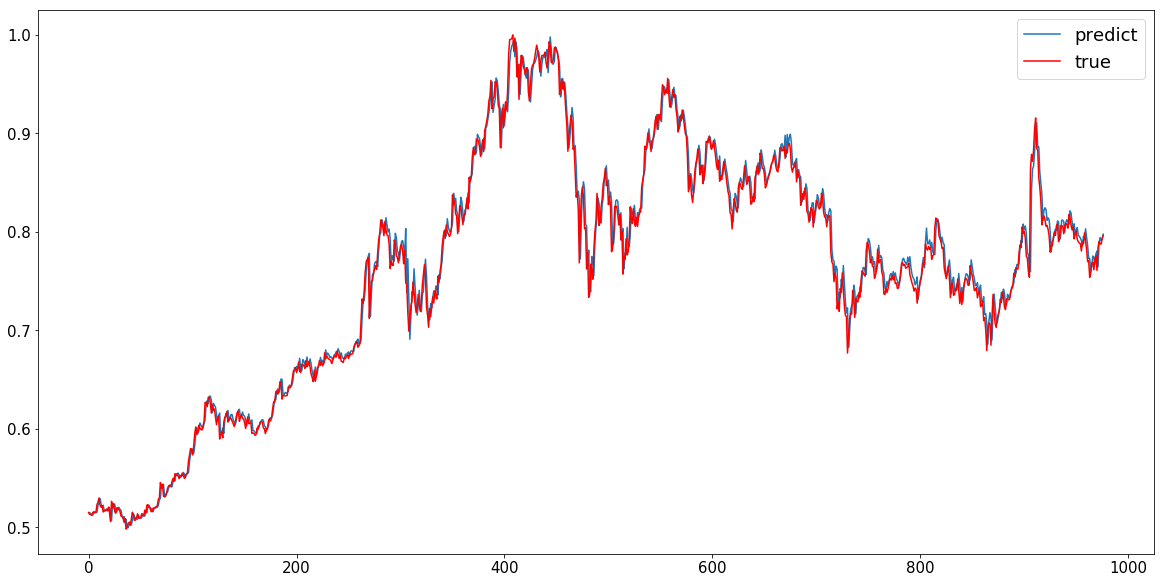

Test RMSE: 0.01270
Test MAE: 0.00887
Test MSE: 0.00016
Test RMSE: 99819745.55707
Test MAE: 69738496.00000


In [19]:
from sklearn.metrics import *
from matplotlib import pyplot
yhat = model.predict([testX])
yhat=yhat.reshape(-1,1)

plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY,'r', label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)

yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)


rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(yhat_inverse, testY_inverse)
print('Test MAE: %.5f' % mae)

In [52]:
model.load_weights("saved_weights/btc_lstmcnn_24.hdf5")

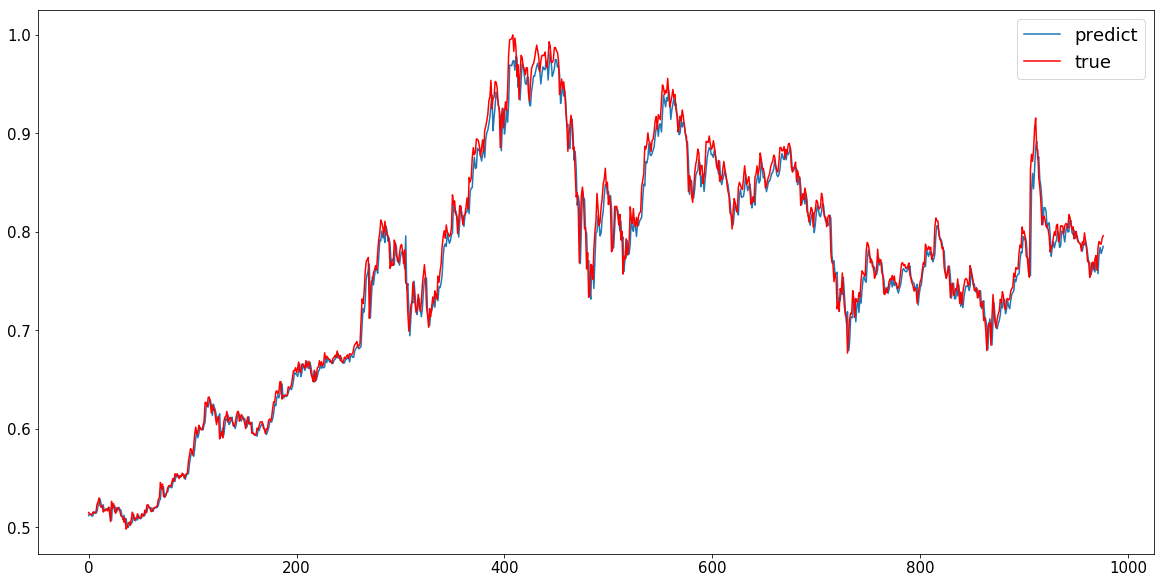

Test RMSE: 0.01354
Test MAE: 0.00963
Test MSE: 0.00018
Test RMSE: 43443156.15564
Test MAE: 12615609.00000


In [53]:
from sklearn.metrics import *
from matplotlib import pyplot
yhat = model.predict([testX])
yhat=yhat.reshape(-1,1)

plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY,'r', label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)

testY=testY.reshape(-1,1)
yhat_inverse = yhat*(values.max(axis=0)-values.min(axis=0))+values.min(axis=0)
testY_inverse=testY*(values.max(axis=0)-values.min(axis=0))+values.min(axis=0)



rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(yhat_inverse, testY_inverse)
print('Test MAE: %.5f' % mae)

In [17]:

def gradient_weight(seq, model):

    seq = tf.Variable(seq[np.newaxis,:,:], dtype=tf.float32)

    with tf.GradientTape() as tape:
        predictions = model(seq)

    grad = tape.gradient(predictions, seq)
    #gr=grads
    #grads = tf.reduce_mean(grads, axis=1).numpy()[0]
    
    return grad


In [18]:
SMALL_SIZE = 15
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE) # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE) # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE) # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE) # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE) # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE) # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE) # fontsize of the figure title

In [39]:
test1X.shape

(977, 24, 6)

In [47]:
id_=24*1

testX_inverse=test1X[id_][:,5]
testX_inverse

array([23427., 23349., 23345., 23338., 23433., 23408., 23435., 23441.,
       23728., 23823., 23981., 23692., 23624., 23686., 23445., 23507.,
       23493., 23555., 23488., 23628., 23433., 23083., 23847., 23592.],
      dtype=float32)

[0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1.]


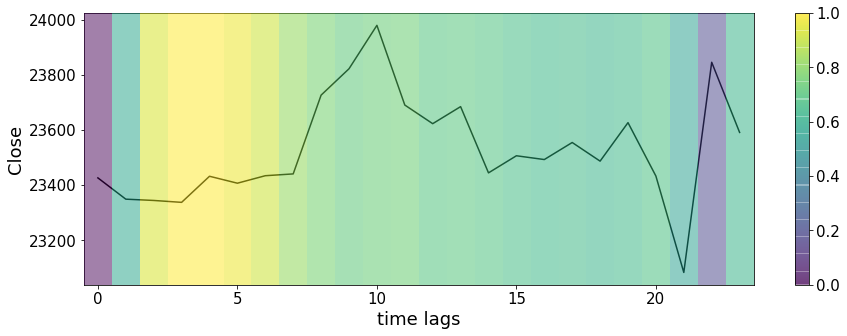

In [48]:

from tensorflow.keras.models import Model
from scipy.ndimage import zoom
import random
import pylab



X_test=testX.copy()
activation = activation_grad(X_test[id_], model)
print(activation)
plt.figure(figsize=(15,5))

plt.plot(testX_inverse, 'k')
#plt.plot(X_test[id_])
#plt.plot(yhat, label='predict')
#plt.plot(testY, label='true')
plt.ylabel('Close'); plt.xlabel('time lags'); #plt.title(pd.to_datetime(test_date[sequence_length+id_]))
plt.twinx()
#plt.xticks(a)
plt.imshow(np.vstack([activation]*120), alpha=0.5, cmap='viridis')
plt.axis('off'); plt.colorbar()
plt.axis('off')
#pylab.pcolor(np.vstack([activation]*120),cmap='jet',alpha=0.35)

#pylab.colorbar()

np.set_printoptions(False)

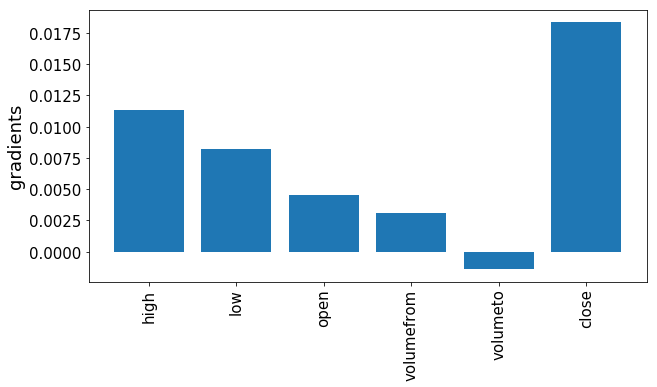

In [50]:
columns=data.columns[1:7]
X_test=testX.copy()

grad_imp = gradient_importance(X_test[id_], model)

plt.figure(figsize=(10,5))
plt.bar(range(len(grad_imp)), grad_imp)
plt.xticks(range(len(columns)), columns, rotation=90)
plt.ylabel('gradients'); #plt.title(pd.to_datetime(test_date[sequence_length+id_]))
np.set_printoptions(False)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


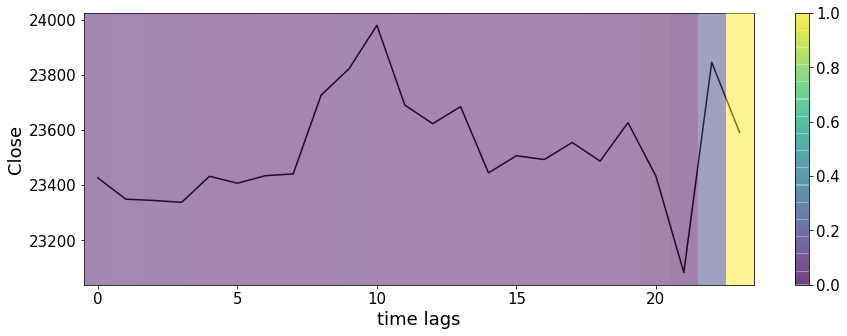

In [54]:

from tensorflow.keras.models import Model
from scipy.ndimage import zoom
import random
import pylab



X_test=testX.copy()
activation = activation_grad(X_test[id_], model)
print(activation)
plt.figure(figsize=(15,5))

plt.plot(testX_inverse, 'k')
#plt.plot(X_test[id_])
#plt.plot(yhat, label='predict')
#plt.plot(testY, label='true')
plt.ylabel('Close'); plt.xlabel('time lags'); #plt.title(pd.to_datetime(test_date[sequence_length+id_]))
plt.twinx()
#plt.xticks(a)
plt.imshow(np.vstack([activation]*120), alpha=0.5, cmap='viridis')
plt.axis('off'); plt.colorbar()
plt.axis('off')
#pylab.pcolor(np.vstack([activation]*120),cmap='jet',alpha=0.35)

#pylab.colorbar()

np.set_printoptions(False)

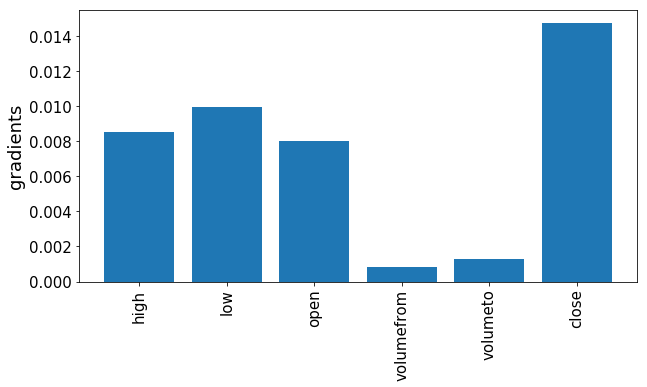

In [55]:
columns=data.columns[1:7]
X_test=testX.copy()

grad_imp = gradient_importance(X_test[id_], model)

plt.figure(figsize=(10,5))
plt.bar(range(len(grad_imp)), grad_imp)
plt.xticks(range(len(columns)), columns, rotation=90)
plt.ylabel('gradients'); #plt.title(pd.to_datetime(test_date[sequence_length+id_]))
np.set_printoptions(False)

(1, 24, 6)


<Figure size 1080x5040 with 0 Axes>

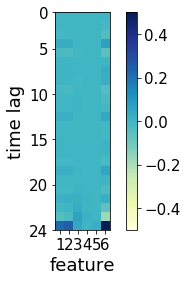

In [80]:
import matplotlib.pyplot as plt
import numpy as np

X_test=testX
grad_weight = gradient_weight(X_test[55], model)

#grad_weight=grad_weight.reshape(48,4)

print(grad_weight.shape)
plt.figure(figsize=(15,70))

#plt.plot(X_test[8], 'k')
a=grad_weight.numpy()
a=a.reshape(24,6)

#print(a)
fig, ax = plt.subplots(1,1)

extent = [0 , 6, 0 , 12]
x_label_list = [1,2,3,4,5,6]
y_label_list = [0,5,10,15,20,24]
ax.set_yticks([24,20,15,10,5,0])

ax.set_xticks([0.5,1.5,2.5,3.5,4.5,5.5])

ax.set_xticklabels(x_label_list)
ax.set_yticklabels(y_label_list)
ax.set_ylabel('time lag')
ax.set_xlabel('feature')

plt.imshow(a,extent = [0 , 6,0,24], vmin=-0.5, vmax=0.5, cmap="YlGnBu", interpolation='nearest')
plt.colorbar()

plt.show()

In [83]:
model.load_weights('saved_weights/btc_reslstmcnn_24.hdf5')

OSError: Unable to open file (unable to open file: name = 'saved_weights/btc_reslstmcnn_24.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

(1, 24, 6)


<Figure size 1080x5040 with 0 Axes>

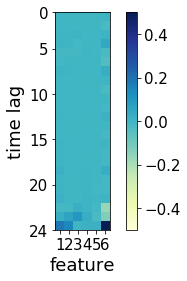

In [85]:
import matplotlib.pyplot as plt
import numpy as np

X_test=testX
grad_weight = gradient_weight(X_test[55], model)

#grad_weight=grad_weight.reshape(48,4)

print(grad_weight.shape)
plt.figure(figsize=(15,70))

#plt.plot(X_test[8], 'k')
a=grad_weight.numpy()
a=a.reshape(24,6)

#print(a)
fig, ax = plt.subplots(1,1)

extent = [0 , 6, 0 , 12]
x_label_list = [1,2,3,4,5,6]
y_label_list = [24,20,15,10,5,0]
ax.set_yticks([0,5,10,15,20,24])

ax.set_xticks([0.5,1.5,2.5,3.5,4.5,5.5])

ax.set_xticklabels(x_label_list)
ax.set_yticklabels(y_label_list)
ax.set_ylabel('time lag')
ax.set_xlabel('feature')

plt.imshow(a,extent = [0 , 6,0,24], vmin=-0.5, vmax=0.5, cmap="YlGnBu", interpolation='nearest')
plt.colorbar()

plt.show()

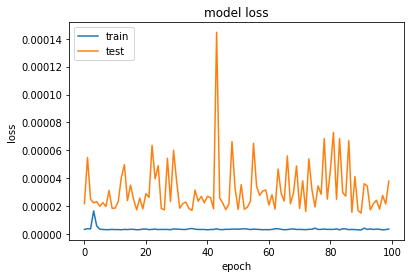

In [49]:

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# 0.01277, 0.01254, 

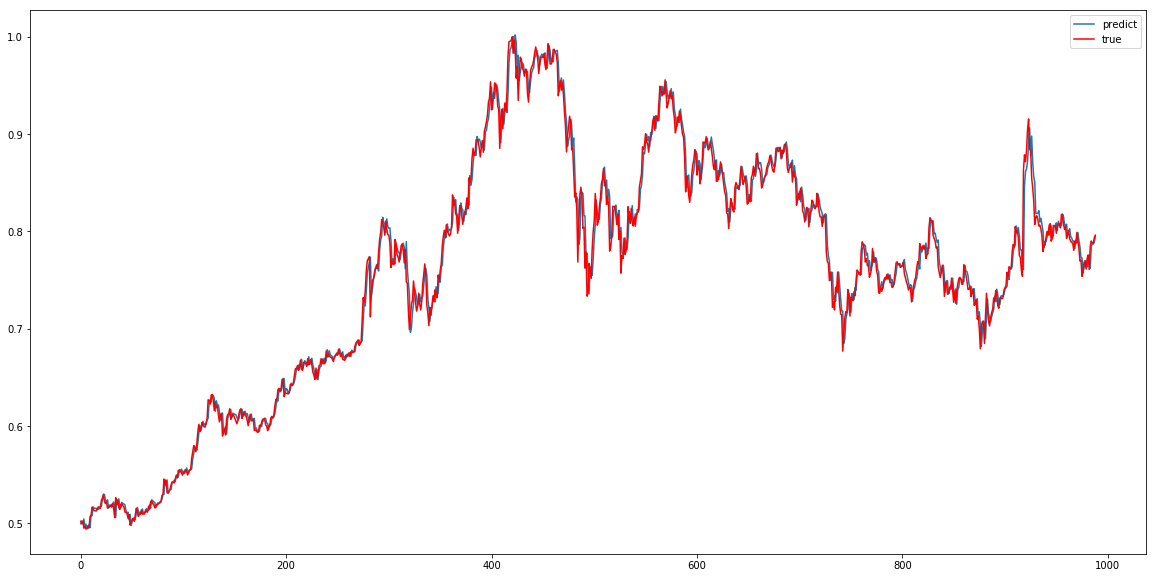

Test RMSE: 0.01254
Test MAE: 0.00860
Test MSE: 0.00016
Test RMSE: 476.80912
Test MAE: 327.09726


In [57]:

from sklearn.metrics import *
from matplotlib import pyplot
yhat = model.predict([testX])
yhat=yhat.reshape(-1,1)

plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY,'r', label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)

yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)


rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(yhat_inverse, testY_inverse)
print('Test MAE: %.5f' % mae)

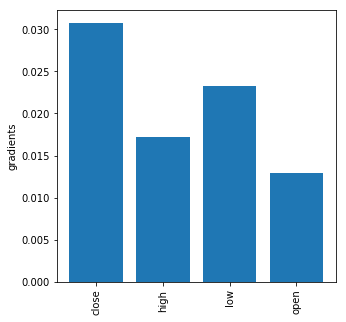

In [16]:
columns='close','high','low','open'

grad_imp = gradient_importance(X_test[id_], model)

plt.figure(figsize=(5,5))
plt.bar(range(len(grad_imp)), grad_imp)
plt.xticks(range(len(columns)), columns, rotation=90)
plt.ylabel('gradients'); #plt.title(pd.to_datetime(test_date[sequence_length+id_]))
np.set_printoptions(False)

## Res lstm-cnn

In [25]:
first_input = Input(shape=(12,6))


in0=LSTM(64,return_sequences=True)(first_input)
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3,activation='relu',padding='same')(in0) #main
#in1= BatchNormalization(scale=False)(in0)
#a=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0) #skip

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

ad=add([in0,in1],name='extractor')
ad=MaxPooling1D(pool_size=2)(ad)#ad=Dropout(0.5)(ad)
#in0=LSTM(64,return_sequences=True)(ad)
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3,activation='relu',padding='same')(ad)
#in1= BatchNormalization(scale=False)(in0)
#b=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(ad) #skip
#ad=add([ad,ad1],name='extractor1')
in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)

in1=Conv1D(filters=64, kernel_size=1 ,activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

ad1=add([in0,in1],name='extractor2')
ad1=MaxPooling1D(pool_size=2)(ad1)#ad=Dropout(0.5)(ad)

#in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(ad1)
#in1= BatchNormalization(scale=False)(in0)

#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=add([ad1,in1],name='extractor2')
#in0=Conv1D(filters=64, kernel_size=5, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)

#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=add([in0,in1])

#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2)(ad1)
in1=Flatten()(ad1)
#in1=Dropout(0.5)(in1)
#in1=Dense(100, activation='relu')(in1)
out=Dense(1,'relu')(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')


model.summary()


checkpoint_path = "saved_weights/btc_reslstmcnn_onestep_relu.hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 12, 6)]      0                                            
__________________________________________________________________________________________________
lstm_3 (LSTM)                   (None, 12, 64)       18176       input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_18 (Conv1D)              (None, 12, 64)       12352       lstm_3[0][0]                     
__________________________________________________________________________________________________
conv1d_19 (Conv1D)              (None, 12, 64)       8256        conv1d_18[0][0]                  
____________________________________________________________________________________________

In [27]:
history=model.fit(trainX, trainY, epochs=400, batch_size=200, validation_data=(valX, valY), verbose=1, callbacks=[cb])

Train on 7992 samples, validate on 988 samples
Epoch 1/400
7200/7992 [==========================>...] - ETA: 0s - loss: 3.3470e-04
Epoch 00001: val_loss improved from inf to 0.00007, saving model to saved_weights/btc_reslstmcnn_onestep_relu.hdf5
7992/7992 [==============================] - 2s 304us/sample - loss: 3.0336e-04 - val_loss: 7.2602e-05
Epoch 2/400
7000/7992 [=========================>....] - ETA: 0s - loss: 1.5014e-05
Epoch 00002: val_loss improved from 0.00007 to 0.00007, saving model to saved_weights/btc_reslstmcnn_onestep_relu.hdf5
7992/7992 [==============================] - 1s 71us/sample - loss: 1.4933e-05 - val_loss: 7.1123e-05
Epoch 3/400
7600/7992 [===========================>..] - ETA: 0s - loss: 1.3675e-05
Epoch 00003: val_loss improved from 0.00007 to 0.00007, saving model to saved_weights/btc_reslstmcnn_onestep_relu.hdf5
7992/7992 [==============================] - 1s 72us/sample - loss: 1.3623e-05 - val_loss: 6.9162e-05
Epoch 4/400
7200/7992 [==================

7600/7992 [===========================>..] - ETA: 0s - loss: 5.3944e-06
Epoch 00063: val_loss improved from 0.00003 to 0.00003, saving model to saved_weights/btc_reslstmcnn_onestep_relu.hdf5
7992/7992 [==============================] - 1s 71us/sample - loss: 5.3229e-06 - val_loss: 3.1093e-05
Epoch 64/400
7600/7992 [===========================>..] - ETA: 0s - loss: 5.7534e-06
Epoch 00064: val_loss did not improve from 0.00003
7992/7992 [==============================] - 1s 68us/sample - loss: 5.6897e-06 - val_loss: 9.5873e-05
Epoch 65/400
7600/7992 [===========================>..] - ETA: 0s - loss: 6.8612e-06
Epoch 00065: val_loss did not improve from 0.00003
7992/7992 [==============================] - 1s 67us/sample - loss: 6.7900e-06 - val_loss: 7.0665e-05
Epoch 66/400
7000/7992 [=========================>....] - ETA: 0s - loss: 5.5893e-06
Epoch 00066: val_loss did not improve from 0.00003
7992/7992 [==============================] - 1s 68us/sample - loss: 5.5772e-06 - val_loss: 8.65

Epoch 96/400
7800/7992 [============================>.] - ETA: 0s - loss: 3.9868e-06
Epoch 00096: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 68us/sample - loss: 3.9694e-06 - val_loss: 2.5742e-05
Epoch 97/400
7400/7992 [==========================>...] - ETA: 0s - loss: 4.1843e-06
Epoch 00097: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 67us/sample - loss: 4.4321e-06 - val_loss: 6.7249e-05
Epoch 98/400
7000/7992 [=========================>....] - ETA: 0s - loss: 4.4613e-06
Epoch 00098: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 68us/sample - loss: 4.5755e-06 - val_loss: 3.0451e-05
Epoch 99/400
7800/7992 [============================>.] - ETA: 0s - loss: 5.8765e-06
Epoch 00099: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 67us/sample - loss: 5.8099e-06 - val_loss: 4.2931e-05
Epoch 100/400
7400/7992 [=======================

7400/7992 [==========================>...] - ETA: 0s - loss: 3.4287e-06
Epoch 00163: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 67us/sample - loss: 3.3900e-06 - val_loss: 5.2855e-05
Epoch 164/400
7800/7992 [============================>.] - ETA: 0s - loss: 3.4560e-06
Epoch 00164: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 67us/sample - loss: 3.4429e-06 - val_loss: 4.9978e-05
Epoch 165/400
7000/7992 [=========================>....] - ETA: 0s - loss: 3.8585e-06
Epoch 00165: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 67us/sample - loss: 3.9971e-06 - val_loss: 2.7026e-05
Epoch 166/400
7200/7992 [==========================>...] - ETA: 0s - loss: 3.5027e-06
Epoch 00166: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 67us/sample - loss: 3.5506e-06 - val_loss: 2.8396e-05
Epoch 167/400
7200/7992 [==========================>...] -

7000/7992 [=========================>....] - ETA: 0s - loss: 3.9695e-06
Epoch 00197: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 68us/sample - loss: 3.9375e-06 - val_loss: 2.4440e-05
Epoch 198/400
7000/7992 [=========================>....] - ETA: 0s - loss: 3.5371e-06
Epoch 00198: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 67us/sample - loss: 3.4514e-06 - val_loss: 2.9159e-05
Epoch 199/400
7800/7992 [============================>.] - ETA: 0s - loss: 3.7293e-06
Epoch 00199: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 67us/sample - loss: 3.6873e-06 - val_loss: 2.2170e-05
Epoch 200/400
7800/7992 [============================>.] - ETA: 0s - loss: 3.4761e-06
Epoch 00200: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 68us/sample - loss: 3.4474e-06 - val_loss: 1.9436e-05
Epoch 201/400
7200/7992 [==========================>...] -

7200/7992 [==========================>...] - ETA: 0s - loss: 2.9844e-06
Epoch 00231: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 67us/sample - loss: 3.0833e-06 - val_loss: 1.8796e-05
Epoch 232/400
7200/7992 [==========================>...] - ETA: 0s - loss: 3.2255e-06
Epoch 00232: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 68us/sample - loss: 3.4430e-06 - val_loss: 6.9017e-05
Epoch 233/400
7200/7992 [==========================>...] - ETA: 0s - loss: 3.7725e-06
Epoch 00233: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 67us/sample - loss: 3.6604e-06 - val_loss: 1.8482e-05
Epoch 234/400
7000/7992 [=========================>....] - ETA: 0s - loss: 3.8657e-06
Epoch 00234: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 68us/sample - loss: 3.7590e-06 - val_loss: 2.5419e-05
Epoch 235/400
7600/7992 [===========================>..] -

7200/7992 [==========================>...] - ETA: 0s - loss: 3.5703e-06
Epoch 00299: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 67us/sample - loss: 3.5130e-06 - val_loss: 3.1985e-05
Epoch 300/400
7600/7992 [===========================>..] - ETA: 0s - loss: 3.2693e-06
Epoch 00300: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 67us/sample - loss: 3.2750e-06 - val_loss: 3.2716e-05
Epoch 301/400
7400/7992 [==========================>...] - ETA: 0s - loss: 3.0516e-06
Epoch 00301: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 67us/sample - loss: 3.0275e-06 - val_loss: 3.7406e-05
Epoch 302/400
7200/7992 [==========================>...] - ETA: 0s - loss: 3.6419e-06
Epoch 00302: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 68us/sample - loss: 3.5335e-06 - val_loss: 4.3963e-05
Epoch 303/400
7400/7992 [==========================>...] -

7200/7992 [==========================>...] - ETA: 0s - loss: 2.9542e-06
Epoch 00367: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 67us/sample - loss: 2.9027e-06 - val_loss: 3.7983e-05
Epoch 368/400
7800/7992 [============================>.] - ETA: 0s - loss: 2.8098e-06
Epoch 00368: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 68us/sample - loss: 2.9206e-06 - val_loss: 8.3106e-05
Epoch 369/400
7400/7992 [==========================>...] - ETA: 0s - loss: 3.8574e-06
Epoch 00369: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 67us/sample - loss: 3.8562e-06 - val_loss: 3.6442e-05
Epoch 370/400
7200/7992 [==========================>...] - ETA: 0s - loss: 3.3735e-06
Epoch 00370: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 67us/sample - loss: 3.2630e-06 - val_loss: 3.1472e-05
Epoch 371/400
7200/7992 [==========================>...] -

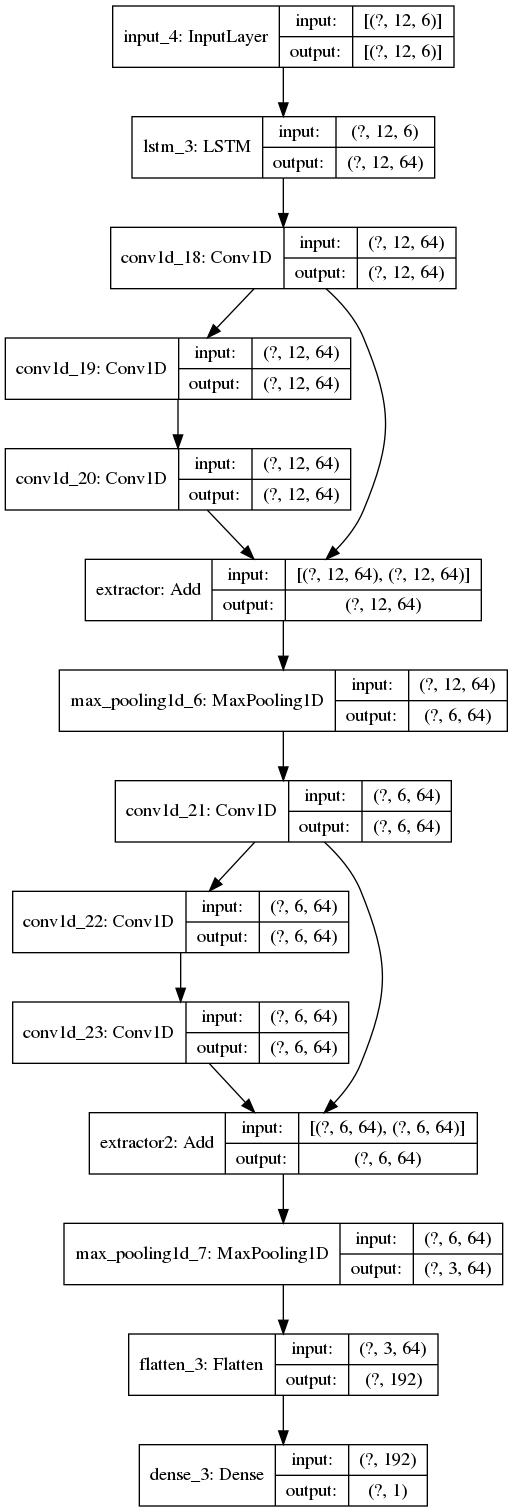

In [26]:
from IPython.display import SVG
from tensorflow.keras.utils import plot_model
%matplotlib inline
dot_img_file = './model.png'

plot_model(model, to_file=dot_img_file, show_shapes=True)

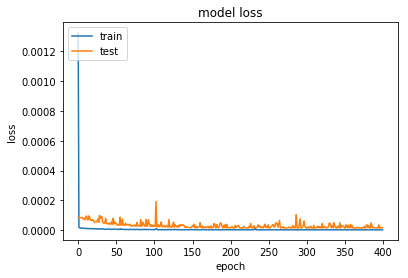

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [60]:
model.load_weights("saved_weights/btc_reslstmcnn_onestep2_.hdf5")

In [28]:
model.load_weights("saved_weights/btc_reslstmcnn_onestep_relu.hdf5")

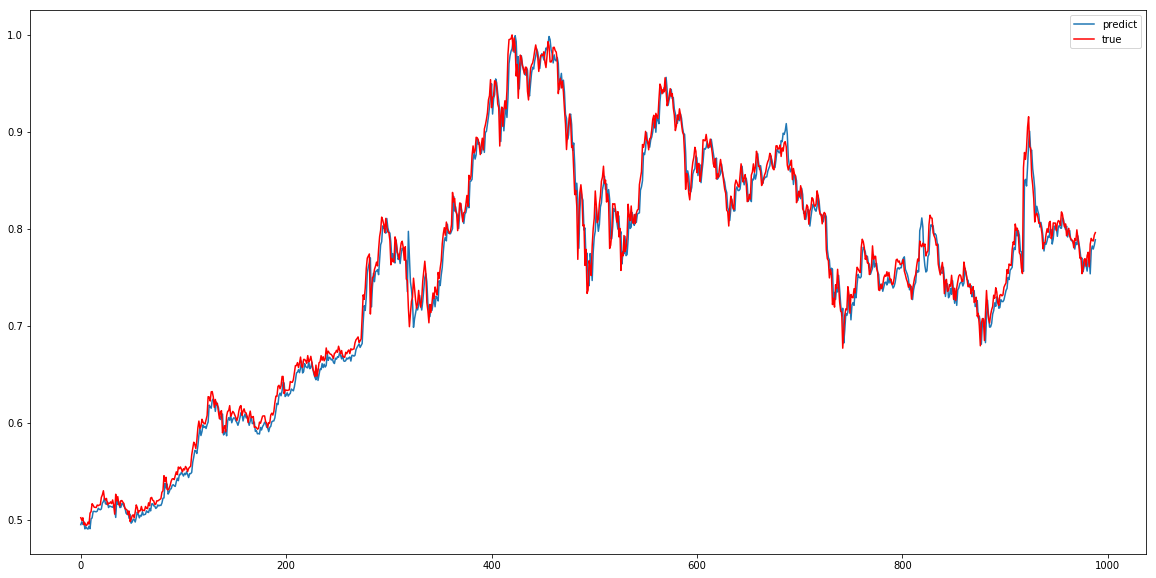

Test RMSE: 0.01381
Test MAE: 0.01007
Test MSE: 0.00019
Test RMSE: 514.58287
Test MAE: 375.20963


In [29]:
from sklearn.metrics import *
from matplotlib import pyplot
yhat = model.predict([testX])
yhat=yhat.reshape(-1,1)

plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY,'r', label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)

testY=testY.reshape(-1,1)
yhat_inverse = yhat*(values.max(axis=0)-values.min(axis=0))+values.min(axis=0)
testY_inverse=testY*(values.max(axis=0)-values.min(axis=0))+values.min(axis=0)
yhat_inverse=yhat_inverse[:,-1]
testY_inverse=testY_inverse[:,-1]

rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(yhat_inverse, testY_inverse)
print('Test MAE: %.5f' % mae)

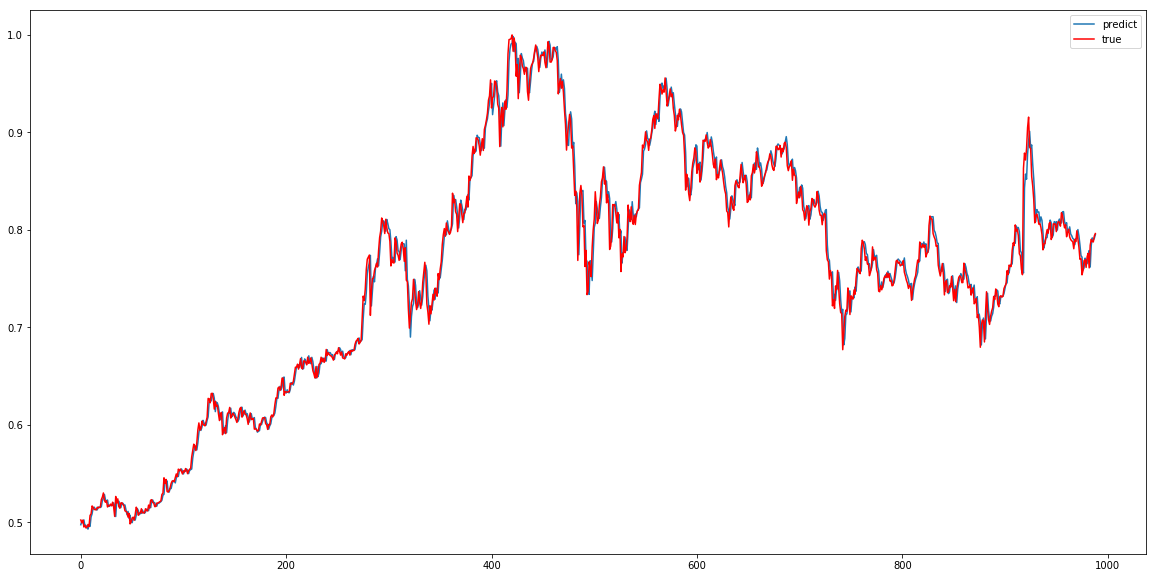

Test RMSE: 0.01228
Test MAE: 0.00848
Test MSE: 0.00015
Test RMSE: 466.82470
Test MAE: 322.26086


In [131]:
#model.load_weights("saved_weights/btc_reslstmcnn_onestep1.hdf5")
from sklearn.metrics import *
from matplotlib import pyplot
yhat = model.predict([testX])
yhat=yhat.reshape(-1,1)

plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY,'r', label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)

yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)


rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(yhat_inverse, testY_inverse)
print('Test MAE: %.5f' % mae)

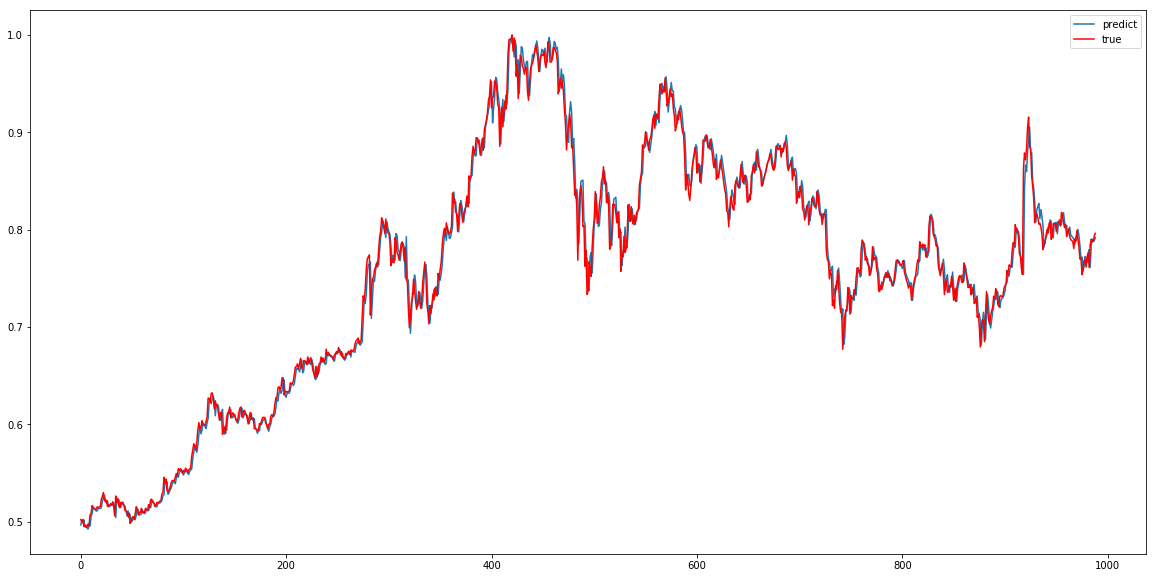

Test RMSE: 0.01249
Test MAE: 0.00866
Test MSE: 0.00016
Test RMSE: 474.64725
Test MAE: 329.23111


In [90]:
from sklearn.metrics import *
from matplotlib import pyplot
yhat = model.predict([testX])
yhat=yhat.reshape(-1,1)

plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY,'r', label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)

yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)


rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(yhat_inverse, testY_inverse)
print('Test MAE: %.5f' % mae)

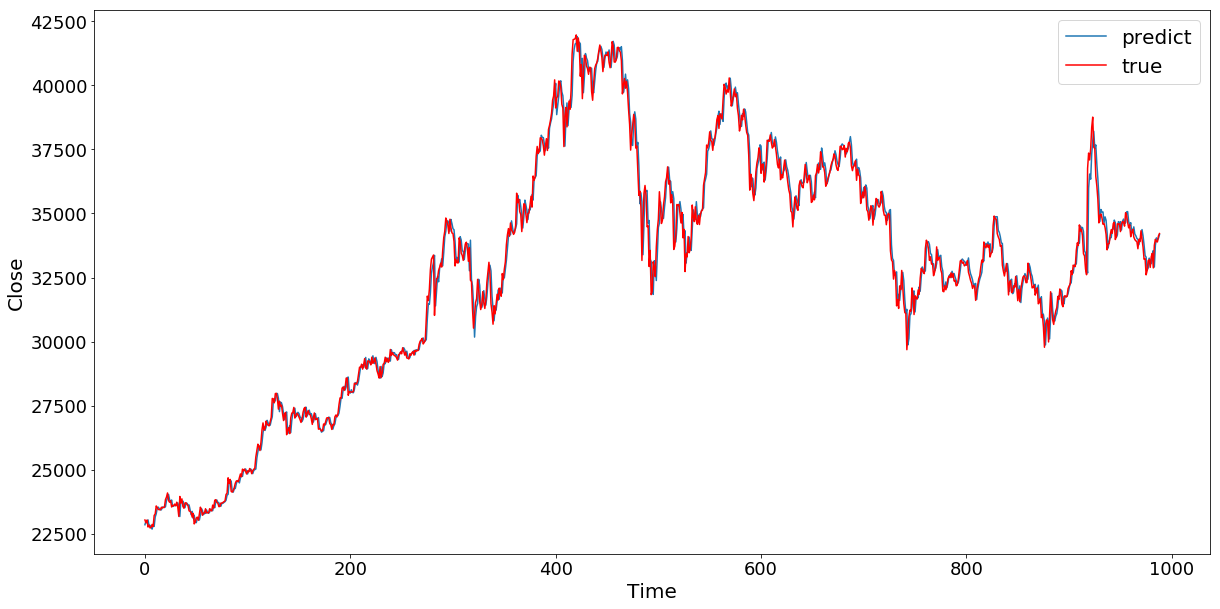

In [133]:
plt.figure(figsize=(20,10))

pyplot.plot(yhat_inverse, label='predict')
pyplot.plot(testY_inverse,'r', label='true')
pyplot.legend()
SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE) # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE) # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE) # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE) # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE) # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE) # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE) # fontsize of the figure title

#
#plt.ylim(23000,27000)
plt.xlabel('Time')

plt.ylabel('Close')

pyplot.show()

### 1D-CNN

In [125]:

first_input = Input(shape=(12,4))

in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(first_input)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)
in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1=add([in0,in1],name='extractor')
#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2)(in1)
in1=Flatten()(in1)
in1=Dense(40, activation='relu')(in1)
out=Dense(1)(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')

model.summary()

checkpoint_path = "saved_weights/btc_1dcnn1.hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)
# fit model

# fit model9
#history=model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

Model: "model_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        [(None, 12, 4)]           0         
_________________________________________________________________
conv1d_150 (Conv1D)          (None, 12, 64)            832       
_________________________________________________________________
conv1d_151 (Conv1D)          (None, 12, 64)            8256      
_________________________________________________________________
conv1d_152 (Conv1D)          (None, 12, 64)            4160      
_________________________________________________________________
conv1d_153 (Conv1D)          (None, 12, 64)            12352     
_________________________________________________________________
conv1d_154 (Conv1D)          (None, 12, 64)            8256      
_________________________________________________________________
conv1d_155 (Conv1D)          (None, 12, 64)            416

In [126]:
history=model.fit(trainX, trainY, epochs=400, batch_size=200, validation_data=(valX, valY), verbose=1, callbacks=[cb])

Train on 7992 samples, validate on 988 samples
Epoch 1/400
6600/7992 [=======================>......] - ETA: 0s - loss: 0.0029
Epoch 00001: val_loss improved from inf to 0.00049, saving model to saved_weights/btc_1dcnn1.hdf5
7992/7992 [==============================] - 1s 87us/sample - loss: 0.0024 - val_loss: 4.9369e-04
Epoch 2/400
6800/7992 [========================>.....] - ETA: 0s - loss: 2.4321e-05
Epoch 00002: val_loss improved from 0.00049 to 0.00010, saving model to saved_weights/btc_1dcnn1.hdf5
7992/7992 [==============================] - 0s 30us/sample - loss: 2.2784e-05 - val_loss: 9.8741e-05
Epoch 3/400
6800/7992 [========================>.....] - ETA: 0s - loss: 1.2487e-05
Epoch 00003: val_loss improved from 0.00010 to 0.00008, saving model to saved_weights/btc_1dcnn1.hdf5
7992/7992 [==============================] - 0s 29us/sample - loss: 1.2106e-05 - val_loss: 7.8433e-05
Epoch 4/400
6600/7992 [=======================>......] - ETA: 0s - loss: 1.2174e-05
Epoch 00004: val_

Epoch 34/400
6800/7992 [========================>.....] - ETA: 0s - loss: 5.5954e-06
Epoch 00034: val_loss did not improve from 0.00006
7992/7992 [==============================] - 0s 27us/sample - loss: 5.3938e-06 - val_loss: 1.7615e-04
Epoch 35/400
6600/7992 [=======================>......] - ETA: 0s - loss: 5.9786e-06
Epoch 00035: val_loss did not improve from 0.00006
7992/7992 [==============================] - 0s 27us/sample - loss: 5.7892e-06 - val_loss: 1.0995e-04
Epoch 36/400
6800/7992 [========================>.....] - ETA: 0s - loss: 6.0909e-06
Epoch 00036: val_loss did not improve from 0.00006
7992/7992 [==============================] - 0s 27us/sample - loss: 5.9388e-06 - val_loss: 1.1360e-04
Epoch 37/400
6800/7992 [========================>.....] - ETA: 0s - loss: 5.9374e-06
Epoch 00037: val_loss did not improve from 0.00006
7992/7992 [==============================] - 0s 26us/sample - loss: 5.9896e-06 - val_loss: 1.0578e-04
Epoch 38/400
6800/7992 [========================

Epoch 68/400
6600/7992 [=======================>......] - ETA: 0s - loss: 8.0514e-06
Epoch 00068: val_loss did not improve from 0.00005
7992/7992 [==============================] - 0s 27us/sample - loss: 9.1075e-06 - val_loss: 6.1973e-05
Epoch 69/400
6800/7992 [========================>.....] - ETA: 0s - loss: 7.1290e-06
Epoch 00069: val_loss did not improve from 0.00005
7992/7992 [==============================] - 0s 26us/sample - loss: 6.7458e-06 - val_loss: 1.8978e-04
Epoch 70/400
6600/7992 [=======================>......] - ETA: 0s - loss: 4.2806e-06
Epoch 00070: val_loss did not improve from 0.00005
7992/7992 [==============================] - 0s 27us/sample - loss: 4.6175e-06 - val_loss: 1.1110e-04
Epoch 71/400
6800/7992 [========================>.....] - ETA: 0s - loss: 4.9144e-06
Epoch 00071: val_loss did not improve from 0.00005
7992/7992 [==============================] - 0s 26us/sample - loss: 4.9493e-06 - val_loss: 1.6847e-04
Epoch 72/400
6800/7992 [========================

Epoch 103/400
6800/7992 [========================>.....] - ETA: 0s - loss: 7.5622e-06
Epoch 00103: val_loss did not improve from 0.00005
7992/7992 [==============================] - 0s 26us/sample - loss: 7.3046e-06 - val_loss: 2.8096e-04
Epoch 104/400
6800/7992 [========================>.....] - ETA: 0s - loss: 6.1448e-06
Epoch 00104: val_loss did not improve from 0.00005
7992/7992 [==============================] - 0s 27us/sample - loss: 6.4242e-06 - val_loss: 2.4301e-04
Epoch 105/400
6800/7992 [========================>.....] - ETA: 0s - loss: 7.9690e-06
Epoch 00105: val_loss did not improve from 0.00005
7992/7992 [==============================] - 0s 27us/sample - loss: 7.2800e-06 - val_loss: 8.5419e-05
Epoch 106/400
6800/7992 [========================>.....] - ETA: 0s - loss: 5.4398e-06
Epoch 00106: val_loss did not improve from 0.00005
7992/7992 [==============================] - 0s 26us/sample - loss: 5.2615e-06 - val_loss: 1.6100e-04
Epoch 107/400
6800/7992 [===================

6800/7992 [========================>.....] - ETA: 0s - loss: 4.3332e-06
Epoch 00171: val_loss did not improve from 0.00005
7992/7992 [==============================] - 0s 26us/sample - loss: 4.4189e-06 - val_loss: 1.9810e-04
Epoch 172/400
6800/7992 [========================>.....] - ETA: 0s - loss: 3.4662e-06
Epoch 00172: val_loss did not improve from 0.00005
7992/7992 [==============================] - 0s 27us/sample - loss: 3.8092e-06 - val_loss: 1.3538e-04
Epoch 173/400
6800/7992 [========================>.....] - ETA: 0s - loss: 3.9658e-06
Epoch 00173: val_loss did not improve from 0.00005
7992/7992 [==============================] - 0s 27us/sample - loss: 3.8390e-06 - val_loss: 2.4002e-04
Epoch 174/400
6800/7992 [========================>.....] - ETA: 0s - loss: 3.9319e-06
Epoch 00174: val_loss did not improve from 0.00005
7992/7992 [==============================] - 0s 26us/sample - loss: 4.1490e-06 - val_loss: 6.2239e-05
Epoch 175/400
6800/7992 [========================>.....] -

6800/7992 [========================>.....] - ETA: 0s - loss: 3.9138e-06
Epoch 00239: val_loss did not improve from 0.00003
7992/7992 [==============================] - 0s 27us/sample - loss: 3.7538e-06 - val_loss: 1.2378e-04
Epoch 240/400
6600/7992 [=======================>......] - ETA: 0s - loss: 2.9310e-06
Epoch 00240: val_loss did not improve from 0.00003
7992/7992 [==============================] - 0s 27us/sample - loss: 3.0401e-06 - val_loss: 9.9260e-05
Epoch 241/400
6600/7992 [=======================>......] - ETA: 0s - loss: 3.1099e-06
Epoch 00241: val_loss did not improve from 0.00003
7992/7992 [==============================] - 0s 27us/sample - loss: 3.1317e-06 - val_loss: 9.8884e-05
Epoch 242/400
6800/7992 [========================>.....] - ETA: 0s - loss: 3.5440e-06
Epoch 00242: val_loss did not improve from 0.00003
7992/7992 [==============================] - 0s 26us/sample - loss: 3.4090e-06 - val_loss: 8.8706e-05
Epoch 243/400
6800/7992 [========================>.....] -

6600/7992 [=======================>......] - ETA: 0s - loss: 2.9993e-06
Epoch 00307: val_loss did not improve from 0.00003
7992/7992 [==============================] - 0s 27us/sample - loss: 2.9654e-06 - val_loss: 1.9787e-04
Epoch 308/400
6800/7992 [========================>.....] - ETA: 0s - loss: 2.8776e-06
Epoch 00308: val_loss did not improve from 0.00003
7992/7992 [==============================] - 0s 27us/sample - loss: 3.1107e-06 - val_loss: 2.1288e-04
Epoch 309/400
6800/7992 [========================>.....] - ETA: 0s - loss: 4.2307e-06
Epoch 00309: val_loss did not improve from 0.00003
7992/7992 [==============================] - 0s 27us/sample - loss: 4.1554e-06 - val_loss: 2.6585e-04
Epoch 310/400
6800/7992 [========================>.....] - ETA: 0s - loss: 3.2931e-06
Epoch 00310: val_loss did not improve from 0.00003
7992/7992 [==============================] - 0s 26us/sample - loss: 3.1816e-06 - val_loss: 1.9766e-04
Epoch 311/400
6800/7992 [========================>.....] -

6600/7992 [=======================>......] - ETA: 0s - loss: 3.0950e-06
Epoch 00375: val_loss did not improve from 0.00003
7992/7992 [==============================] - 0s 27us/sample - loss: 3.2662e-06 - val_loss: 1.2363e-04
Epoch 376/400
6800/7992 [========================>.....] - ETA: 0s - loss: 3.1439e-06
Epoch 00376: val_loss did not improve from 0.00003
7992/7992 [==============================] - 0s 26us/sample - loss: 3.1396e-06 - val_loss: 1.5452e-04
Epoch 377/400
6800/7992 [========================>.....] - ETA: 0s - loss: 3.0421e-06
Epoch 00377: val_loss did not improve from 0.00003
7992/7992 [==============================] - 0s 27us/sample - loss: 3.1616e-06 - val_loss: 7.8695e-05
Epoch 378/400
6800/7992 [========================>.....] - ETA: 0s - loss: 2.8560e-06
Epoch 00378: val_loss did not improve from 0.00003
7992/7992 [==============================] - 0s 27us/sample - loss: 2.9118e-06 - val_loss: 1.6589e-04
Epoch 379/400
6600/7992 [=======================>......] -

In [127]:
model.load_weights("saved_weights/btc_1dcnn1.hdf5")

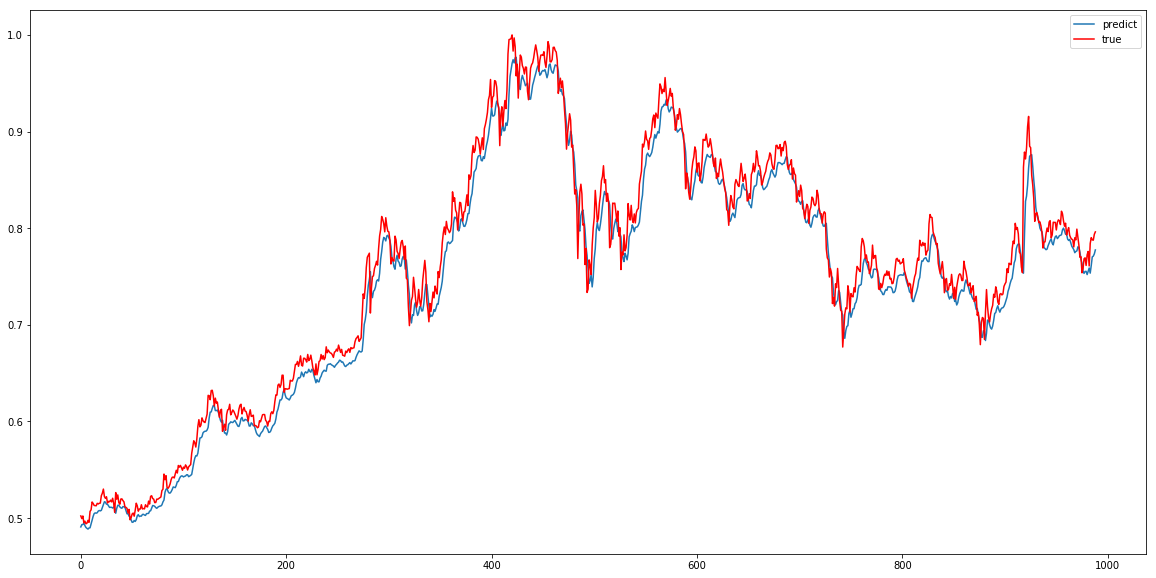

Test RMSE: 0.01913
Test MAE: 0.01545
Test MSE: 0.00037
Test RMSE: 727.21730
Test MAE: 587.44379


In [128]:
from sklearn.metrics import *
from matplotlib import pyplot
yhat = model.predict([testX])
yhat=yhat.reshape(-1,1)

plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY,'r', label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)

yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)


rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(yhat_inverse, testY_inverse)
print('Test MAE: %.5f' % mae)

In [ ]:
#0.01254, 0.01307

### CNN-LSTM

In [141]:
from tensorflow.keras.models import Model

first_input = Input(shape=(12,4))

#in1=LSTM(units =150 , return_sequences=True)(first_input)

#in1=TimeDistributed(Conv1D(filters=64, kernel_size=2, activation='relu'))(in1)
#in1= BatchNormalization(scale=False)(in1)
in1=Conv1D(filters=64, kernel_size=3, activation='relu')(first_input)
#in1= BatchNormalization(scale=False)(in0)
in1=Conv1D(filters=64, kernel_size=2, activation='relu')(in1)

in1=Conv1D(filters=64, kernel_size=1, activation='relu')(in1)
in1=Conv1D(filters=64, kernel_size=3, activation='relu')(in1)
#in1= BatchNormalization(scale=False)(in0)
in1=Conv1D(filters=64, kernel_size=2, activation='relu')(in1)

in1=Conv1D(filters=64, kernel_size=1, activation='relu')(in1)
#in1=add([in0,in1],name='extractor')
#in1=MaxPooling1D(pool_size=2,name='extractor')(in1)

#in1=Flatten()(in1)
#model.add(LSTM(units = 128, return_sequences=True))
in1=LSTM(units =64 , return_sequences=False)(in1)
#lstm_out=Bidirectional(LSTM(units =100 , return_sequences=False))(lstm_out)

#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1, in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2)(in1)

#flat_out = Flatten()(in1)
#flat_out=Dense(20, activation='relu')(flat_out)
#model.add(Dropout(drop_dense))
#in1=Dense(100)(in1)
#in1=Dropout(0.5)(in1)
out1=Dense(1, activation = 'relu')(in1)
model=Model(inputs=first_input, outputs=out1)
model.compile(optimizer='adam', loss='mse')

checkpoint_path = "saved_weights/btc_cnnlstm.hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)


In [142]:
model.summary()

Model: "model_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_33 (InputLayer)        [(None, 12, 4)]           0         
_________________________________________________________________
conv1d_168 (Conv1D)          (None, 10, 64)            832       
_________________________________________________________________
conv1d_169 (Conv1D)          (None, 9, 64)             8256      
_________________________________________________________________
conv1d_170 (Conv1D)          (None, 9, 64)             4160      
_________________________________________________________________
conv1d_171 (Conv1D)          (None, 7, 64)             12352     
_________________________________________________________________
conv1d_172 (Conv1D)          (None, 6, 64)             8256      
_________________________________________________________________
conv1d_173 (Conv1D)          (None, 6, 64)             416

In [143]:
history=model.fit(trainX, trainY, epochs=400, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

Train on 7992 samples, validate on 988 samples
Epoch 1/400
7100/7992 [=========================>....] - ETA: 0s - loss: 0.0013
Epoch 00001: val_loss improved from inf to 0.00024, saving model to saved_weights/btc_cnnlstm.hdf5
7992/7992 [==============================] - 2s 240us/sample - loss: 0.0011 - val_loss: 2.3929e-04
Epoch 2/400
7300/7992 [==========================>...] - ETA: 0s - loss: 1.3937e-05
Epoch 00002: val_loss improved from 0.00024 to 0.00011, saving model to saved_weights/btc_cnnlstm.hdf5
7992/7992 [==============================] - 1s 68us/sample - loss: 1.3776e-05 - val_loss: 1.0694e-04
Epoch 3/400
7300/7992 [==========================>...] - ETA: 0s - loss: 1.4222e-05
Epoch 00003: val_loss improved from 0.00011 to 0.00008, saving model to saved_weights/btc_cnnlstm.hdf5
7992/7992 [==============================] - 1s 66us/sample - loss: 1.3921e-05 - val_loss: 8.4070e-05
Epoch 4/400
7300/7992 [==========================>...] - ETA: 0s - loss: 1.3650e-05
Epoch 00004: 

Epoch 35/400
7300/7992 [==========================>...] - ETA: 0s - loss: 6.7618e-06
Epoch 00035: val_loss did not improve from 0.00007
7992/7992 [==============================] - 1s 63us/sample - loss: 7.2675e-06 - val_loss: 1.2456e-04
Epoch 36/400
7300/7992 [==========================>...] - ETA: 0s - loss: 9.8730e-06
Epoch 00036: val_loss did not improve from 0.00007
7992/7992 [==============================] - 1s 63us/sample - loss: 9.9449e-06 - val_loss: 1.3053e-04
Epoch 37/400
7300/7992 [==========================>...] - ETA: 0s - loss: 9.8072e-06
Epoch 00037: val_loss did not improve from 0.00007
7992/7992 [==============================] - 1s 64us/sample - loss: 9.7687e-06 - val_loss: 1.4883e-04
Epoch 38/400
7200/7992 [==========================>...] - ETA: 0s - loss: 8.3490e-06
Epoch 00038: val_loss did not improve from 0.00007
7992/7992 [==============================] - 1s 64us/sample - loss: 8.1405e-06 - val_loss: 1.9497e-04
Epoch 39/400
7300/7992 [========================

Epoch 70/400
7300/7992 [==========================>...] - ETA: 0s - loss: 5.0449e-06
Epoch 00070: val_loss did not improve from 0.00007
7992/7992 [==============================] - 1s 63us/sample - loss: 4.9494e-06 - val_loss: 2.1745e-04
Epoch 71/400
7300/7992 [==========================>...] - ETA: 0s - loss: 4.0901e-06
Epoch 00071: val_loss did not improve from 0.00007
7992/7992 [==============================] - 1s 64us/sample - loss: 4.3740e-06 - val_loss: 1.8585e-04
Epoch 72/400
7300/7992 [==========================>...] - ETA: 0s - loss: 5.0942e-06
Epoch 00072: val_loss did not improve from 0.00007
7992/7992 [==============================] - 1s 63us/sample - loss: 5.7615e-06 - val_loss: 3.5742e-04
Epoch 73/400
7300/7992 [==========================>...] - ETA: 0s - loss: 4.1760e-06
Epoch 00073: val_loss did not improve from 0.00007
7992/7992 [==============================] - 1s 63us/sample - loss: 4.4222e-06 - val_loss: 1.4367e-04
Epoch 74/400
7300/7992 [========================

Epoch 104/400
7300/7992 [==========================>...] - ETA: 0s - loss: 4.2430e-06
Epoch 00104: val_loss did not improve from 0.00004
7992/7992 [==============================] - 1s 63us/sample - loss: 4.2491e-06 - val_loss: 1.4445e-04
Epoch 105/400
7200/7992 [==========================>...] - ETA: 0s - loss: 3.6492e-06
Epoch 00105: val_loss did not improve from 0.00004
7992/7992 [==============================] - 1s 64us/sample - loss: 3.7632e-06 - val_loss: 7.7825e-05
Epoch 106/400
7300/7992 [==========================>...] - ETA: 0s - loss: 3.8103e-06
Epoch 00106: val_loss did not improve from 0.00004
7992/7992 [==============================] - 1s 64us/sample - loss: 3.7237e-06 - val_loss: 1.3588e-04
Epoch 107/400
7300/7992 [==========================>...] - ETA: 0s - loss: 3.8348e-06
Epoch 00107: val_loss did not improve from 0.00004
7992/7992 [==============================] - 1s 63us/sample - loss: 4.0658e-06 - val_loss: 1.1248e-04
Epoch 108/400
7300/7992 [===================

Epoch 172/400
7200/7992 [==========================>...] - ETA: 0s - loss: 4.2455e-06
Epoch 00172: val_loss did not improve from 0.00003
7992/7992 [==============================] - 1s 63us/sample - loss: 4.1886e-06 - val_loss: 6.0021e-05
Epoch 173/400
7300/7992 [==========================>...] - ETA: 0s - loss: 3.4211e-06
Epoch 00173: val_loss did not improve from 0.00003
7992/7992 [==============================] - 1s 63us/sample - loss: 3.3687e-06 - val_loss: 3.2233e-05
Epoch 174/400
7300/7992 [==========================>...] - ETA: 0s - loss: 3.7503e-06
Epoch 00174: val_loss did not improve from 0.00003
7992/7992 [==============================] - 1s 64us/sample - loss: 3.6296e-06 - val_loss: 3.3765e-05
Epoch 175/400
7300/7992 [==========================>...] - ETA: 0s - loss: 3.4202e-06
Epoch 00175: val_loss did not improve from 0.00003
7992/7992 [==============================] - 1s 63us/sample - loss: 3.3528e-06 - val_loss: 4.2850e-05
Epoch 176/400
7300/7992 [===================

Epoch 206/400
7300/7992 [==========================>...] - ETA: 0s - loss: 5.8577e-06
Epoch 00206: val_loss did not improve from 0.00003
7992/7992 [==============================] - 1s 63us/sample - loss: 5.7123e-06 - val_loss: 3.6324e-05
Epoch 207/400
7300/7992 [==========================>...] - ETA: 0s - loss: 5.2586e-06
Epoch 00207: val_loss did not improve from 0.00003
7992/7992 [==============================] - 1s 63us/sample - loss: 5.0807e-06 - val_loss: 6.0026e-05
Epoch 208/400
7300/7992 [==========================>...] - ETA: 0s - loss: 3.2402e-06
Epoch 00208: val_loss improved from 0.00003 to 0.00003, saving model to saved_weights/btc_cnnlstm.hdf5
7992/7992 [==============================] - 1s 67us/sample - loss: 3.2780e-06 - val_loss: 2.5639e-05
Epoch 209/400
7300/7992 [==========================>...] - ETA: 0s - loss: 3.5957e-06
Epoch 00209: val_loss did not improve from 0.00003
7992/7992 [==============================] - 1s 63us/sample - loss: 3.7556e-06 - val_loss: 1.1

Epoch 240/400
7300/7992 [==========================>...] - ETA: 0s - loss: 4.9171e-06
Epoch 00240: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 63us/sample - loss: 4.8549e-06 - val_loss: 9.8770e-05
Epoch 241/400
7300/7992 [==========================>...] - ETA: 0s - loss: 3.6520e-06
Epoch 00241: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 63us/sample - loss: 3.6325e-06 - val_loss: 3.3043e-05
Epoch 242/400
7300/7992 [==========================>...] - ETA: 0s - loss: 4.3700e-06
Epoch 00242: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 64us/sample - loss: 4.3002e-06 - val_loss: 8.0197e-05
Epoch 243/400
7300/7992 [==========================>...] - ETA: 0s - loss: 3.6654e-06
Epoch 00243: val_loss did not improve from 0.00002
7992/7992 [==============================] - 0s 62us/sample - loss: 3.5858e-06 - val_loss: 6.2886e-05
Epoch 244/400
7300/7992 [===================

Epoch 274/400
7300/7992 [==========================>...] - ETA: 0s - loss: 3.6850e-06
Epoch 00274: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 63us/sample - loss: 3.6516e-06 - val_loss: 3.7152e-05
Epoch 275/400
7300/7992 [==========================>...] - ETA: 0s - loss: 3.5898e-06
Epoch 00275: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 63us/sample - loss: 3.4838e-06 - val_loss: 4.0641e-05
Epoch 276/400
7300/7992 [==========================>...] - ETA: 0s - loss: 3.7514e-06
Epoch 00276: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 63us/sample - loss: 3.6509e-06 - val_loss: 2.9999e-05
Epoch 277/400
7300/7992 [==========================>...] - ETA: 0s - loss: 3.6727e-06
Epoch 00277: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 64us/sample - loss: 3.5874e-06 - val_loss: 4.7439e-05
Epoch 278/400
7300/7992 [===================

Epoch 342/400
7300/7992 [==========================>...] - ETA: 0s - loss: 3.4574e-06
Epoch 00342: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 64us/sample - loss: 3.3915e-06 - val_loss: 3.9243e-05
Epoch 343/400
7300/7992 [==========================>...] - ETA: 0s - loss: 3.7024e-06
Epoch 00343: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 63us/sample - loss: 3.6667e-06 - val_loss: 3.6497e-05
Epoch 344/400
7300/7992 [==========================>...] - ETA: 0s - loss: 3.1790e-06
Epoch 00344: val_loss improved from 0.00002 to 0.00002, saving model to saved_weights/btc_cnnlstm.hdf5
7992/7992 [==============================] - 1s 67us/sample - loss: 3.1481e-06 - val_loss: 1.9777e-05
Epoch 345/400
7300/7992 [==========================>...] - ETA: 0s - loss: 3.1875e-06
Epoch 00345: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 63us/sample - loss: 3.2387e-06 - val_loss: 2.4

Epoch 376/400
7300/7992 [==========================>...] - ETA: 0s - loss: 3.0234e-06
Epoch 00376: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 63us/sample - loss: 3.1142e-06 - val_loss: 6.5048e-05
Epoch 377/400
7300/7992 [==========================>...] - ETA: 0s - loss: 3.4973e-06
Epoch 00377: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 63us/sample - loss: 3.4977e-06 - val_loss: 3.8638e-05
Epoch 378/400
7300/7992 [==========================>...] - ETA: 0s - loss: 3.1651e-06
Epoch 00378: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 64us/sample - loss: 3.2363e-06 - val_loss: 2.2295e-05
Epoch 379/400
7300/7992 [==========================>...] - ETA: 0s - loss: 3.9754e-06
Epoch 00379: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 64us/sample - loss: 3.9598e-06 - val_loss: 9.4813e-05
Epoch 380/400
7300/7992 [===================

In [144]:
model.load_weights("saved_weights/btc_cnnlstm.hdf5")

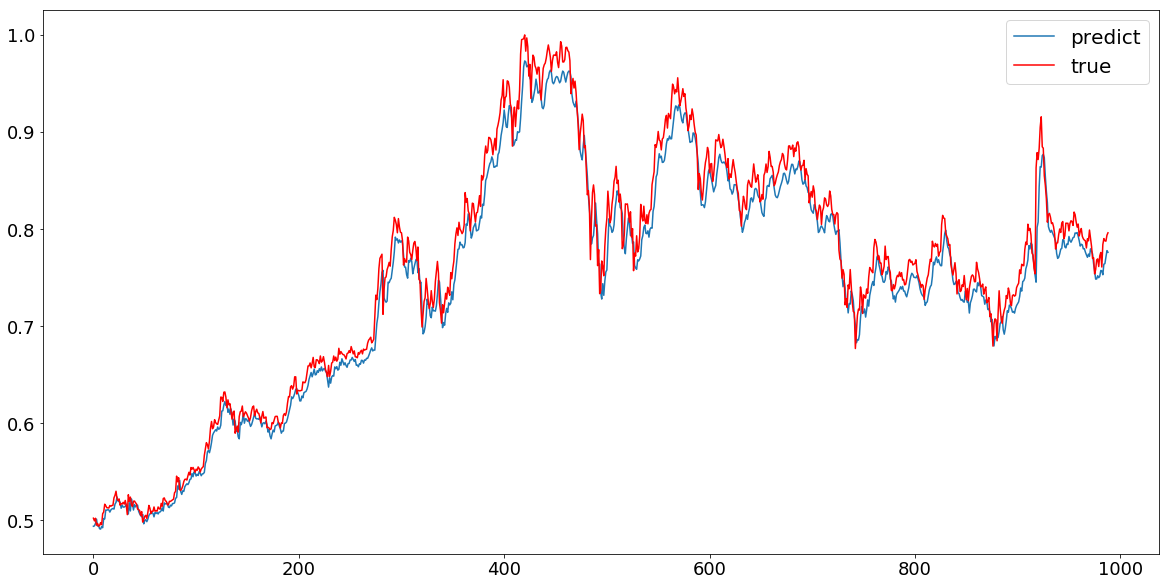

Test RMSE: 0.02010
Test MAE: 0.01604
Test MSE: 0.00040


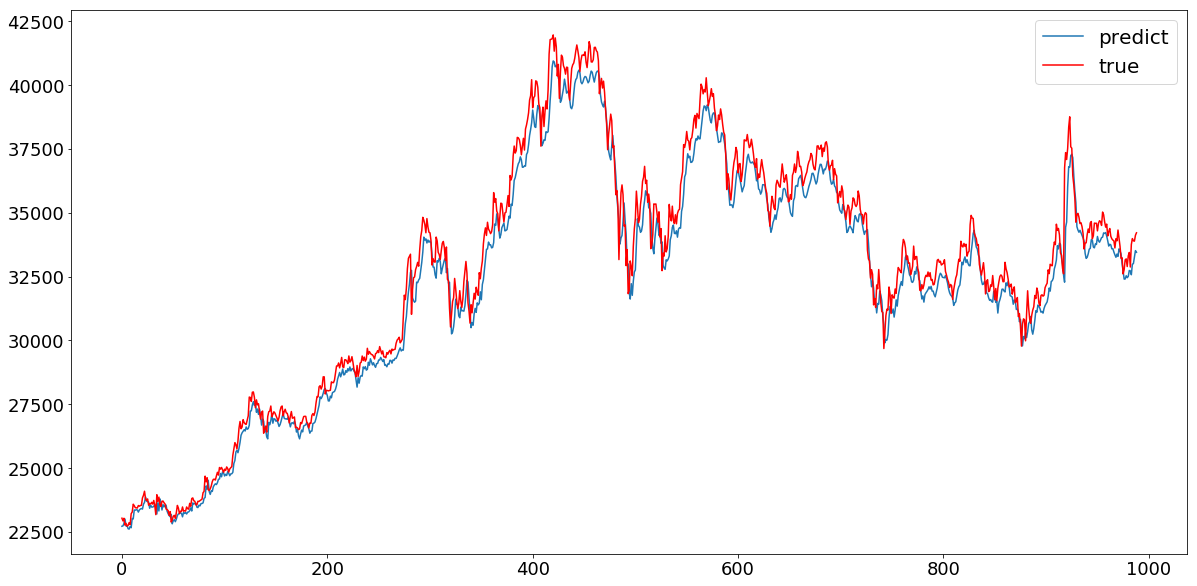

Test RMSE: 764.21455
Test MAE: 609.71100


In [145]:
## 1dcnn(5,3,1)-lstm

from matplotlib import pyplot
from sklearn.metrics import *

yhat = model.predict([testX])
yhat=yhat.reshape(-1,1)
plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY,'r', label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)

yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)

plt.figure(figsize=(20,10))

pyplot.plot(yhat_inverse, label='predict')
pyplot.plot(testY_inverse,'r', label='true')
pyplot.legend()
pyplot.show()

rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(yhat_inverse, testY_inverse)
print('Test MAE: %.5f' % mae)

### Timedistributed LSTM-CNN

In [58]:
trainX = np.reshape(trainX, (trainX.shape[0],1, trainX.shape[1], trainX.shape[2]))
valX = np.reshape(valX, (valX.shape[0],1, valX.shape[1],valX.shape[2]))
testX = np.reshape(testX, (testX.shape[0],1,testX.shape[1], testX.shape[2] ))

In [59]:
from tensorflow.keras.models import *

first_input = Input(shape=(None,12,4))

in1=TimeDistributed(LSTM(units =150 , return_sequences=True))(first_input)

in0=TimeDistributed(Conv1D(filters=64, kernel_size=5, activation='relu'))(in1)
#in1= BatchNormalization(scale=False)(in1)
#in0=TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'))(in1)
#in1= BatchNormalization(scale=False)(in0)

in1=TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'))(in0)

#in1=add([in0,in1])
in1=TimeDistributed(MaxPooling1D(pool_size=2,name='extractor'))(in1)

in1=TimeDistributed(Flatten())(in1)

#model.add(LSTM(units = 128, return_sequences=True))
#in1=LSTM(units =150 , return_sequences=False)(in1)
#lstm_out=Bidirectional(LSTM(units =100 , return_sequences=False))(lstm_out)

#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1, in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2)(in1)

#flat_out = Flatten()(in1)
#flat_out=Dense(20, activation='relu')(flat_out)
#model.add(Dropout(drop_dense))
out1=Dense(1, activation = 'relu')(in1)
model=Model(inputs=first_input, outputs=out1)
model.compile(optimizer='adam', loss='mse')

checkpoint_path = "saved_weights/btc_timelstmcnn15051.hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)


In [60]:
model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, None, 12, 4)]     0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, None, 12, 150)     93000     
_________________________________________________________________
time_distributed_6 (TimeDist (None, None, 8, 64)       48064     
_________________________________________________________________
time_distributed_7 (TimeDist (None, None, 8, 64)       4160      
_________________________________________________________________
time_distributed_8 (TimeDist (None, None, 4, 64)       0         
_________________________________________________________________
time_distributed_9 (TimeDist (None, None, 256)         0         
_________________________________________________________________
dense_8 (Dense)              (None, None, 1)           257 

In [61]:
## timedistribute lstm(100)-1dcnn

history=model.fit(trainX, trainY, epochs=500, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

Train on 7992 samples, validate on 988 samples
Epoch 1/500
7600/7992 [===========================>..] - ETA: 0s - loss: 0.0066
Epoch 00001: val_loss improved from inf to 0.00009, saving model to saved_weights/btc_timelstmcnn15051.hdf5
7992/7992 [==============================] - 2s 295us/sample - loss: 0.0063 - val_loss: 8.7779e-05
Epoch 2/500
7600/7992 [===========================>..] - ETA: 0s - loss: 1.5365e-05
Epoch 00002: val_loss improved from 0.00009 to 0.00007, saving model to saved_weights/btc_timelstmcnn15051.hdf5
7992/7992 [==============================] - 1s 130us/sample - loss: 1.5299e-05 - val_loss: 7.4714e-05
Epoch 3/500
7600/7992 [===========================>..] - ETA: 0s - loss: 1.4275e-05
Epoch 00003: val_loss did not improve from 0.00007
7992/7992 [==============================] - 1s 127us/sample - loss: 1.4482e-05 - val_loss: 8.1972e-05
Epoch 4/500
7600/7992 [===========================>..] - ETA: 0s - loss: 1.4418e-05
Epoch 00004: val_loss did not improve from 0.

7600/7992 [===========================>..] - ETA: 0s - loss: 4.4545e-06
Epoch 00066: val_loss improved from 0.00003 to 0.00002, saving model to saved_weights/btc_timelstmcnn15051.hdf5
7992/7992 [==============================] - 1s 130us/sample - loss: 4.4319e-06 - val_loss: 2.3323e-05
Epoch 67/500
7500/7992 [===========================>..] - ETA: 0s - loss: 4.2562e-06
Epoch 00067: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 128us/sample - loss: 4.4418e-06 - val_loss: 7.9263e-05
Epoch 68/500
7600/7992 [===========================>..] - ETA: 0s - loss: 5.1003e-06
Epoch 00068: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 128us/sample - loss: 5.0474e-06 - val_loss: 2.9409e-05
Epoch 69/500
7600/7992 [===========================>..] - ETA: 0s - loss: 6.1647e-06
Epoch 00069: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 128us/sample - loss: 6.1135e-06 - val_loss: 3.4487e

Epoch 100/500
7600/7992 [===========================>..] - ETA: 0s - loss: 4.3146e-06
Epoch 00100: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 127us/sample - loss: 4.3722e-06 - val_loss: 6.3380e-05
Epoch 101/500
7600/7992 [===========================>..] - ETA: 0s - loss: 4.3996e-06
Epoch 00101: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 128us/sample - loss: 4.3314e-06 - val_loss: 6.0241e-05
Epoch 102/500
7600/7992 [===========================>..] - ETA: 0s - loss: 4.6931e-06
Epoch 00102: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 128us/sample - loss: 4.7646e-06 - val_loss: 3.3265e-05
Epoch 103/500
7600/7992 [===========================>..] - ETA: 0s - loss: 3.8254e-06
Epoch 00103: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 127us/sample - loss: 3.7706e-06 - val_loss: 2.8591e-05
Epoch 104/500
7600/7992 [===============

Epoch 134/500
7600/7992 [===========================>..] - ETA: 0s - loss: 3.8564e-06
Epoch 00134: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 128us/sample - loss: 3.8791e-06 - val_loss: 2.6503e-05
Epoch 135/500
7600/7992 [===========================>..] - ETA: 0s - loss: 3.6719e-06
Epoch 00135: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 127us/sample - loss: 3.6446e-06 - val_loss: 2.8661e-05
Epoch 136/500
7600/7992 [===========================>..] - ETA: 0s - loss: 3.8404e-06
Epoch 00136: val_loss improved from 0.00002 to 0.00002, saving model to saved_weights/btc_timelstmcnn15051.hdf5
7992/7992 [==============================] - 1s 130us/sample - loss: 3.8419e-06 - val_loss: 1.6353e-05
Epoch 137/500
7600/7992 [===========================>..] - ETA: 0s - loss: 4.5429e-06- ETA: 0s - lo
Epoch 00137: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 128us/sample - loss:

Epoch 168/500
7600/7992 [===========================>..] - ETA: 0s - loss: 3.4373e-06
Epoch 00168: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 128us/sample - loss: 3.4292e-06 - val_loss: 2.0408e-05
Epoch 169/500
7600/7992 [===========================>..] - ETA: 0s - loss: 3.9957e-06
Epoch 00169: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 129us/sample - loss: 3.9705e-06 - val_loss: 2.3028e-05
Epoch 170/500
7600/7992 [===========================>..] - ETA: 0s - loss: 3.6323e-06
Epoch 00170: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 128us/sample - loss: 3.5999e-06 - val_loss: 5.7255e-05
Epoch 171/500
7600/7992 [===========================>..] - ETA: 0s - loss: 3.7014e-06
Epoch 00171: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 128us/sample - loss: 3.6962e-06 - val_loss: 2.6410e-05
Epoch 172/500
7600/7992 [===============

Epoch 202/500
7600/7992 [===========================>..] - ETA: 0s - loss: 3.9987e-06
Epoch 00202: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 129us/sample - loss: 3.9996e-06 - val_loss: 3.7585e-05
Epoch 203/500
7600/7992 [===========================>..] - ETA: 0s - loss: 3.5423e-06
Epoch 00203: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 128us/sample - loss: 3.6372e-06 - val_loss: 1.5509e-05
Epoch 204/500
7600/7992 [===========================>..] - ETA: 0s - loss: 3.9870e-06
Epoch 00204: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 128us/sample - loss: 4.1851e-06 - val_loss: 2.5556e-05
Epoch 205/500
7600/7992 [===========================>..] - ETA: 0s - loss: 3.6639e-06
Epoch 00205: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 128us/sample - loss: 3.8447e-06 - val_loss: 1.9155e-05
Epoch 206/500
7600/7992 [===============

Epoch 270/500
7600/7992 [===========================>..] - ETA: 0s - loss: 3.2533e-06
Epoch 00270: val_loss did not improve from 0.00001
7992/7992 [==============================] - 1s 127us/sample - loss: 3.1967e-06 - val_loss: 1.6718e-05
Epoch 271/500
7600/7992 [===========================>..] - ETA: 0s - loss: 3.5925e-06
Epoch 00271: val_loss improved from 0.00001 to 0.00001, saving model to saved_weights/btc_timelstmcnn15051.hdf5
7992/7992 [==============================] - 1s 129us/sample - loss: 3.6608e-06 - val_loss: 1.4498e-05
Epoch 272/500
7600/7992 [===========================>..] - ETA: 0s - loss: 3.4121e-06
Epoch 00272: val_loss did not improve from 0.00001
7992/7992 [==============================] - 1s 128us/sample - loss: 3.3736e-06 - val_loss: 2.1516e-05
Epoch 273/500
7600/7992 [===========================>..] - ETA: 0s - loss: 3.3002e-06
Epoch 00273: val_loss did not improve from 0.00001
7992/7992 [==============================] - 1s 128us/sample - loss: 3.2375e-06 - 

Epoch 304/500
7500/7992 [===========================>..] - ETA: 0s - loss: 3.2118e-06
Epoch 00304: val_loss did not improve from 0.00001
7992/7992 [==============================] - 1s 128us/sample - loss: 3.2745e-06 - val_loss: 2.0259e-05
Epoch 305/500
7600/7992 [===========================>..] - ETA: 0s - loss: 3.3743e-06
Epoch 00305: val_loss did not improve from 0.00001
7992/7992 [==============================] - 1s 128us/sample - loss: 3.5561e-06 - val_loss: 1.8281e-05
Epoch 306/500
7600/7992 [===========================>..] - ETA: 0s - loss: 3.3074e-06
Epoch 00306: val_loss did not improve from 0.00001
7992/7992 [==============================] - 1s 128us/sample - loss: 3.2706e-06 - val_loss: 3.8210e-05
Epoch 307/500
7600/7992 [===========================>..] - ETA: 0s - loss: 3.3223e-06
Epoch 00307: val_loss did not improve from 0.00001
7992/7992 [==============================] - 1s 128us/sample - loss: 3.3360e-06 - val_loss: 1.8800e-05
Epoch 308/500
7600/7992 [===============

Epoch 338/500
7600/7992 [===========================>..] - ETA: 0s - loss: 3.0828e-06
Epoch 00338: val_loss did not improve from 0.00001
7992/7992 [==============================] - 1s 127us/sample - loss: 3.0433e-06 - val_loss: 1.5533e-05
Epoch 339/500
7600/7992 [===========================>..] - ETA: 0s - loss: 3.2500e-06
Epoch 00339: val_loss did not improve from 0.00001
7992/7992 [==============================] - 1s 128us/sample - loss: 3.2243e-06 - val_loss: 1.6163e-05
Epoch 340/500
7600/7992 [===========================>..] - ETA: 0s - loss: 3.7061e-06
Epoch 00340: val_loss improved from 0.00001 to 0.00001, saving model to saved_weights/btc_timelstmcnn15051.hdf5
7992/7992 [==============================] - 1s 129us/sample - loss: 3.6571e-06 - val_loss: 1.4333e-05
Epoch 341/500
7600/7992 [===========================>..] - ETA: 0s - loss: 3.3755e-06
Epoch 00341: val_loss did not improve from 0.00001
7992/7992 [==============================] - 1s 129us/sample - loss: 3.3118e-06 - 

Epoch 372/500
7600/7992 [===========================>..] - ETA: 0s - loss: 3.3841e-06
Epoch 00372: val_loss did not improve from 0.00001
7992/7992 [==============================] - 1s 128us/sample - loss: 3.3596e-06 - val_loss: 1.8291e-05
Epoch 373/500
7600/7992 [===========================>..] - ETA: 0s - loss: 3.2782e-06
Epoch 00373: val_loss did not improve from 0.00001
7992/7992 [==============================] - 1s 128us/sample - loss: 3.4838e-06 - val_loss: 4.7663e-05
Epoch 374/500
7600/7992 [===========================>..] - ETA: 0s - loss: 3.1171e-06
Epoch 00374: val_loss did not improve from 0.00001
7992/7992 [==============================] - 1s 127us/sample - loss: 3.1187e-06 - val_loss: 1.7693e-05
Epoch 375/500
7600/7992 [===========================>..] - ETA: 0s - loss: 3.1329e-06
Epoch 00375: val_loss did not improve from 0.00001
7992/7992 [==============================] - 1s 128us/sample - loss: 3.1391e-06 - val_loss: 1.7726e-05
Epoch 376/500
7600/7992 [===============

7600/7992 [===========================>..] - ETA: 0s - loss: 3.3817e-06
Epoch 00440: val_loss did not improve from 0.00001
7992/7992 [==============================] - 1s 128us/sample - loss: 3.3190e-06 - val_loss: 1.5579e-05
Epoch 441/500
7600/7992 [===========================>..] - ETA: 0s - loss: 2.9195e-06
Epoch 00441: val_loss did not improve from 0.00001
7992/7992 [==============================] - 1s 127us/sample - loss: 2.9722e-06 - val_loss: 1.8242e-05
Epoch 442/500
7600/7992 [===========================>..] - ETA: 0s - loss: 3.1910e-06
Epoch 00442: val_loss did not improve from 0.00001
7992/7992 [==============================] - 1s 128us/sample - loss: 3.1324e-06 - val_loss: 1.5950e-05
Epoch 443/500
7600/7992 [===========================>..] - ETA: 0s - loss: 3.0436e-06
Epoch 00443: val_loss did not improve from 0.00001
7992/7992 [==============================] - 1s 127us/sample - loss: 3.0664e-06 - val_loss: 2.7938e-05
Epoch 444/500
7600/7992 [===========================>.

In [62]:
model.load_weights("saved_weights/btc_timelstmcnn15051.hdf5")

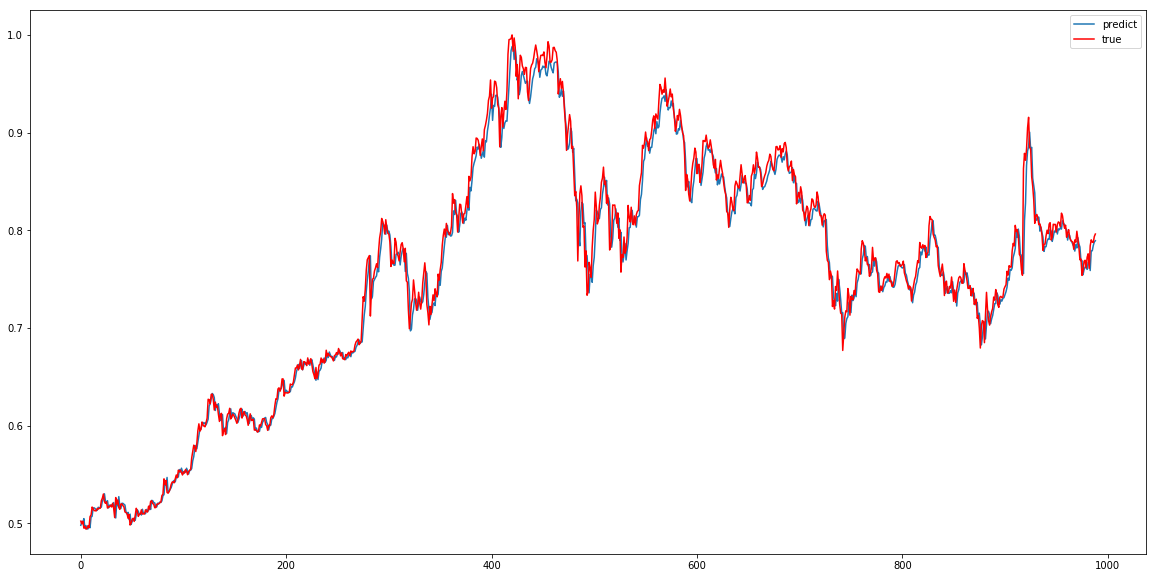

Test RMSE: 0.01382
Test MAE: 0.00973
Test MSE: 0.00019


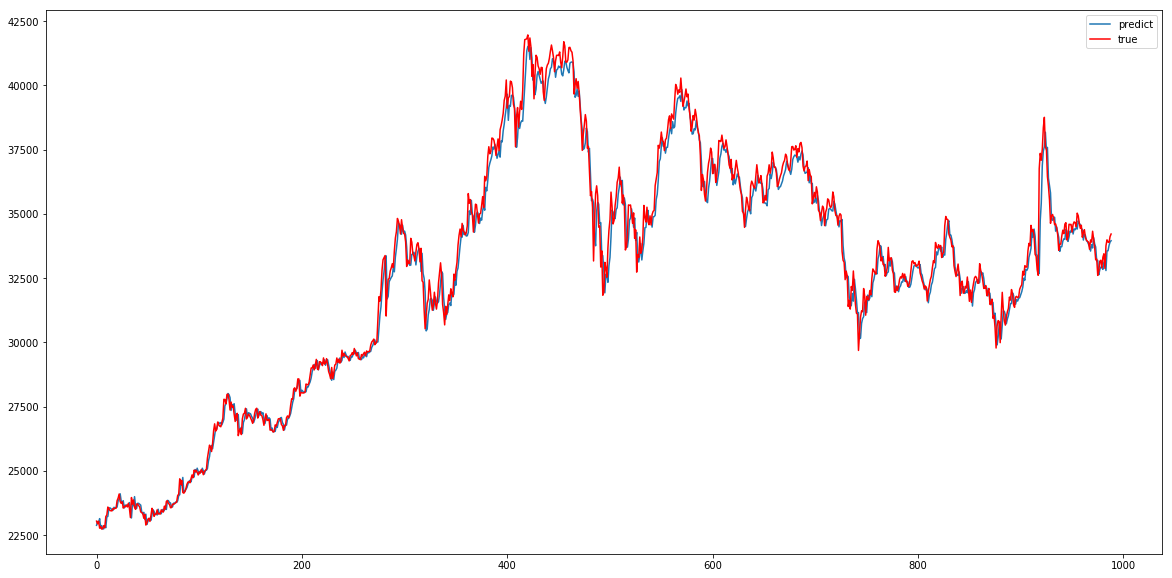

Test RMSE: 525.32457
Test MAE: 369.98352


In [63]:

## timedistributed lstm150-1dcnn(5,1)

from matplotlib import pyplot
from sklearn.metrics import *

yhat = model.predict([testX])
yhat=yhat.reshape(-1,1)
plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY,'r', label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)

yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)

plt.figure(figsize=(20,10))

pyplot.plot(yhat_inverse, label='predict')
pyplot.plot(testY_inverse,'r', label='true')
pyplot.legend()
pyplot.show()

rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(yhat_inverse, testY_inverse)
print('Test MAE: %.5f' % mae)

### visualize

In [14]:
def gradient_importance(seq, model):

    seq = tf.Variable(seq[np.newaxis,:,:], dtype=tf.float32)

    with tf.GradientTape() as tape:
        predictions = model(seq)

    grads = tape.gradient(predictions, seq)
    grads = tf.reduce_mean(grads, axis=1).numpy()[0]
    
    return grads



def activation_grad(seq, model):
    
    seq = seq[np.newaxis,:,:]
    grad_model = Model([model.inputs], 
                       [model.get_layer('extractor').output, 
                        model.output])

    # Obtain the predicted value and the intermediate filters
    with tf.GradientTape() as tape:
        seq_outputs, predictions = grad_model(seq)

    # Extract filters and gradients
    output = seq_outputs[0]
    grads = tape.gradient(predictions, seq_outputs)[0]

    # Average gradients spatially
    weights = tf.reduce_mean(grads, axis=0)
    
    # Get a ponderated map of filters according to grad importance
    cam = np.ones(output.shape[0], dtype=np.float32)
    for index, w in enumerate(weights):
        cam += w * output[:, index]

    time = int(seq.shape[1]/output.shape[0])
    cam = zoom(cam.numpy(), time, order=1)
    heatmap = (cam - cam.min())/(cam.max() - cam.min())
    
    return heatmap

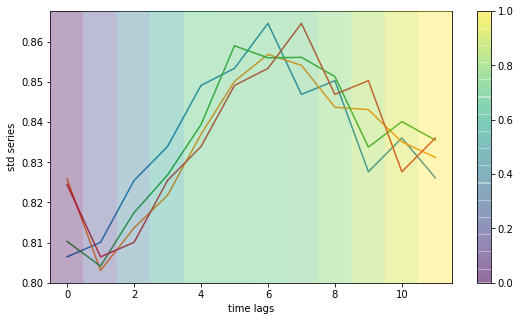

In [94]:
from scipy.ndimage import zoom
import random
id_=random.randint(0,len(testX))


X_test=testX.copy()
activation = activation_grad(X_test[id_], model)

plt.figure(figsize=(9,5))
plt.plot(X_test[id_])
#plt.plot(yhat, label='predict')
#plt.plot(testY, label='true')
plt.ylabel('std series'); plt.xlabel('time lags'); #plt.title(pd.to_datetime(test_date[sequence_length+id_]))
plt.twinx()
#plt.xticks(a)
plt.imshow(np.vstack([activation]*30), alpha=0.35)
plt.axis('off'); plt.colorbar()
np.set_printoptions(False)

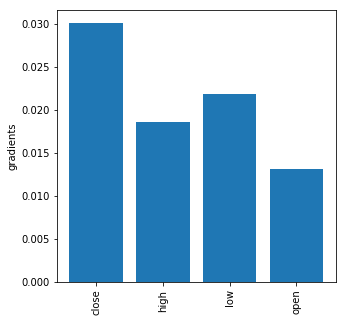

In [92]:
columns='close','high','low','open'

grad_imp = gradient_importance(X_test[id_], model)

plt.figure(figsize=(5,5))
plt.bar(range(len(grad_imp)), grad_imp)
plt.xticks(range(len(columns)), columns, rotation=90)
plt.ylabel('gradients'); #plt.title(pd.to_datetime(test_date[sequence_length+id_]))
np.set_printoptions(False)